# Projet 5 : Segmentez des clients d'un site e-commerce

### Contexte : 

- Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

- Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

- Nous devons fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.


Notre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.

### Objectif : Un notebook de l'analyse exploratoire (non cleané, pour comprendre votre démarche).

- Un notebook (ou code commenté au choix) d’essais des différentes approches de modélisation (non cleané, pour comprendre votre démarche).
Un notebook de simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation.
Un support de présentation pour présenter votre travail à un collègue.

## SOMMAIRE : 

- 1 ) Description des données
    * 1.1 ) chargement des différents données
    * 1.2 ) Jointure des différents jeu de données <br></br>
    
- 2 ) Features Engineering 

- 3 ) Exploration du datasets final

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns 
from math import radians,cos,sin,asin,sqrt

In [2]:
# Versions

from datetime import datetime
print('Version des librairies utilisées :')
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Matplotlib            : ' + mpl.__version__)
print('Seaborn               : ' + sns.__version__)

#
now = datetime.now().isoformat()

print('Lancé le           : ' + now)

Version des librairies utilisées :
Python                : 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.21.5
Pandas                : 1.4.2
Matplotlib            : 3.5.1
Seaborn               : 0.11.2
Lancé le           : 2022-11-21T15:39:59.289040


### 1)  Description des données

Nous allons importer les différents datasets et faire une courte analyse pour avoir une visualisation des informations globales :

In [3]:
df = pd.read_csv('olist_customers_dataset.csv')

In [4]:
df.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

In [5]:
df.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [6]:
df.describe()

customer_zip_code_prefix
count              99441.000000
mean               35137.474583
std                29797.938996
min                 1003.000000
25%                11347.000000
50%                24416.000000
75%                58900.000000
max                99990.000000

------

Partie nécessaire à la représentation cartographique plus tard dans le notebook :
 - Cartographies
 - Graphiques : Dépense |Type de paiement | Délai de livraison | Région

In [7]:
import requests

In [8]:
olist_customer = pd.read_csv('olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
olist_orders = pd.read_csv('olist_orders_dataset.csv')
olist_order_items = pd.read_csv('olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
olist_products = pd.read_csv('olist_products_dataset.csv')
olist_sellers = pd.read_csv('olist_sellers_dataset.csv')

In [9]:
# Collections for each dataset
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

------------

#### 1.1 Chargement des différents données 

In [10]:
df_customers = pd.read_csv("olist_customers_dataset.csv")
print("Cinq premières observations du fichier olist_customers_dataset.csv ")
display(df_customers.head())
print(f"Nombre d'observations du dataset: {df_customers.shape[0]}, nombre de variables {df_customers.shape[1]}\n")
df_customers.info()
print("-"*150)

df_geolocation = pd.read_csv("olist_geolocation_dataset.csv")
print("Cinq premières observations du fichier olist_geolocation_dataset.csv")
display(df_geolocation.head())
print(f"Nombre d'observations du dataset: {df_geolocation.shape[0]}, nombre de variables {df_geolocation.shape[1]}\n")
df_geolocation.info()
df_geolocation.describe()
print("-"*150)

df_order = pd.read_csv("olist_order_items_dataset.csv")
print("Cinq premières observations du fichier olist_order_items_dataset.csv")
display(df_order.head())
print(f"Nombre d'observations du dataset: {df_order.shape[0]}, nombre de variables {df_order.shape[1]}\n")
df_order.info()
print("-"*150)

df_opayments = pd.read_csv("olist_order_payments_dataset.csv")
print("Cinq premières observations du fichier olist_order_payments_dataset.csv")
display(df_opayments.head())
print(f"Nombre d'observations du dataset: {df_opayments.shape[0]}, nombre de variables {df_opayments.shape[1]}\n")
df_opayments.info()
print("-"*150)

df_oreview = pd.read_csv("olist_order_reviews_dataset.csv")
print("Cinq premières observations du fichier olist_order_reviews_dataset.csv")
display(df_oreview.head())
print(f"Nombre d'observations du dataset: {df_oreview.shape[0]}, nombre de variables {df_oreview.shape[1]}\n")
df_oreview.info()
print("-"*150)

df_odataset = pd.read_csv("olist_orders_dataset.csv")
print("Cinq premières observations du fichier olist_orders_dataset.csv")
display(df_odataset.head())
print(f"Nombre d'observations du dataset: {df_odataset.shape[0]}, nombre de variables {df_odataset.shape[1]}\n")
df_odataset.info()
print("-"*150)

df_productd = pd.read_csv("olist_products_dataset.csv")
print("Cinq premières observations du fichier olist_products_dataset.csv")
display(df_productd.head())
print(f"Nombre d'observations du dataset: {df_productd.shape[0]}, nombre de variables {df_productd.shape[1]}\n")
df_productd.info()
print("-"*150)

df_sellers = pd.read_csv("olist_sellers_dataset.csv")
print("Cinq premières observations du fichier olist_sellers_dataset.csv")
display(df_sellers.head())
print(f"Nombre d'observations du dataset: {df_sellers.shape[0]}, nombre de variables {df_sellers.shape[1]}\n")
df_sellers.info()
print("-"*150)

df_productcatname = pd.read_csv("product_category_name_translation.csv")
print("Cinq premières observations du fichier product_category_name_translation.csv")
display(df_productcatname.head())
print(f"Nombre d'observations du dataset: {df_productcatname.shape[0]}, nombre de variables {df_productcatname.shape[1]}\n")
df_productcatname.info()
print("-"*150)

Cinq premières observations du fichier olist_customers_dataset.csv 


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

Nombre d'observations du dataset: 99441, nombre de variables 5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
------------------------------------------------------------------------------------------------------------------------------------------------------
Cinq premières observations du fichier olist_geolocation_dataset.csv


geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

Nombre d'observations du dataset: 1000163, nombre de variables 5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
------------------------------------------------------------------------------------------------------------------------------------------------------
Cinq premières observations du fichier olist_order_items_dataset.csv


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

Nombre d'observations du dataset: 112650, nombre de variables 7

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
------------------------------------------------------------------------------------------------------------------------------------------------------
Cinq premières observations du fichier olist_order_payments_dataset.csv


order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

Nombre d'observations du dataset: 103886, nombre de variables 5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
------------------------------------------------------------------------------------------------------------------------------------------------------
Cinq premières observations du fichier olist_order_reviews_dataset.csv


review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

Nombre d'observations du dataset: 99224, nombre de variables 7

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
------------------------------------------------------------------------------------------------------------------------------------------------------
Cinq premières observations du fichier olist_orders_dataset.csv


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

Nombre d'observations du dataset: 99441, nombre de variables 8

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
------------------------------------------------------------------------------------------------------------------------------------------------------
Cinq premières observations du fichier olist_pr

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

Nombre d'observations du dataset: 32951, nombre de variables 9

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
-----------------------------------------------------------------------------------------------------------------------------------------------------

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

Nombre d'observations du dataset: 3095, nombre de variables 4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
------------------------------------------------------------------------------------------------------------------------------------------------------
Cinq premières observations du fichier product_category_name_translation.csv


product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

Nombre d'observations du dataset: 71, nombre de variables 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB
------------------------------------------------------------------------------------------------------------------------------------------------------


Remarque : 

Résumé des nos données : 

<strong>Les Clients</strong>
- "Olist_customers" : les variables importantes :
    * customer_id : "ID Key "des commandes
    * customer_unique_id : Identifiant unique du client
    * customer_state : Etat du client (Geographique) 

    => Pas de valeurs manquantes 


--------------------------

<strong>Les données de géolocalisation</strong>
- 'olist_geolocation" : les variables importantes :
    * "geolocation_zip_code_prefix" : ID lié au datasets clients
    * Plus d'un millions de lignes 

    => Pas de valeurs manquantes

--------------------------
<strong>Les commandes clients</strong>

- 'olist_orders_dataset' : les variables importantes :
    * 'order_id' : Les entêtes des commandes
    * "Customers_id" : liées un compte unique client ( Customer_id <-> Order_id)

- 'order_id' : les variables importantes:
    * order_id : Identifiant unique de la commande
    * order_item_id : Identifiant séquentiel des items d'une même commande (lignes de commande)
    * product_id : Identifiant unique du produit
    * seller_id : Identifiant unique du vendeur
    * price : Prix de la ligne de commande
    * freight_value : Coût de fret de la ligne (Si plusieurs lignes, le coût de fret est réparti entre toutes les lignes)

- 'olist_order_payments_datasets' : les variables importantes :
    * payment_sequential : Si plusieurs méthodes de paiement appliquées, une ligne est crée par moyen utulisé.
    * payment_installments : Nombre de versements choisis

- 'order_reviews' : Info général sur les avis clients liées à une commande :    

    * Review score + Review_comment_date/title/message = NOTE + COMMENTAIRE 


------------------------------------
<strong>Les produits</strong>

- 'olist_products_dataset' : Regroupe les catégories de produits ainsi que les diverses caractéristiques des produit : description, dimensions et poids 

- 'olist_product_category_name_translation" : Regroupe les noms des catégories des différentes produits traduites. 

### 1.2 ) Jointure des différents jeu de données 

Joiture : Produit et Catégories : 

Nous allons créer des nouveaux datasets plus complet en réalisant des jointures entre <strong> les datasets Produit et Catégories </strong>, en supprimant les features les moins pertinentes pour notre projet.  

In [11]:
products = pd.merge(df_productd,df_productcatname,how='left',on='product_category_name')

In [12]:
# Supprision des feautures non nécessaire

del_features_list = ['product_category_name',"product_weight_g","product_length_cm","product_height_cm","product_width_cm"]

products.drop(del_features_list,axis=1,inplace=True)

products = products.rename(columns={'product_category_name_english':'product_category_name'})

In [13]:
products.head()

product_id  product_name_lenght  \
0  1e9e8ef04dbcff4541ed26657ea517e5                 40.0   
1  3aa071139cb16b67ca9e5dea641aaa2f                 44.0   
2  96bd76ec8810374ed1b65e291975717f                 46.0   
3  cef67bcfe19066a932b7673e239eb23d                 27.0   
4  9dc1a7de274444849c219cff195d0b71                 37.0   

   product_description_lenght  product_photos_qty product_category_name  
0                       287.0                 1.0             perfumery  
1                       276.0                 1.0                   art  
2                       250.0                 1.0        sports_leisure  
3                       261.0                 1.0                  baby  
4                       402.0                 4.0            housewares

Visualisation de la répartition des diverses catégories de produits :

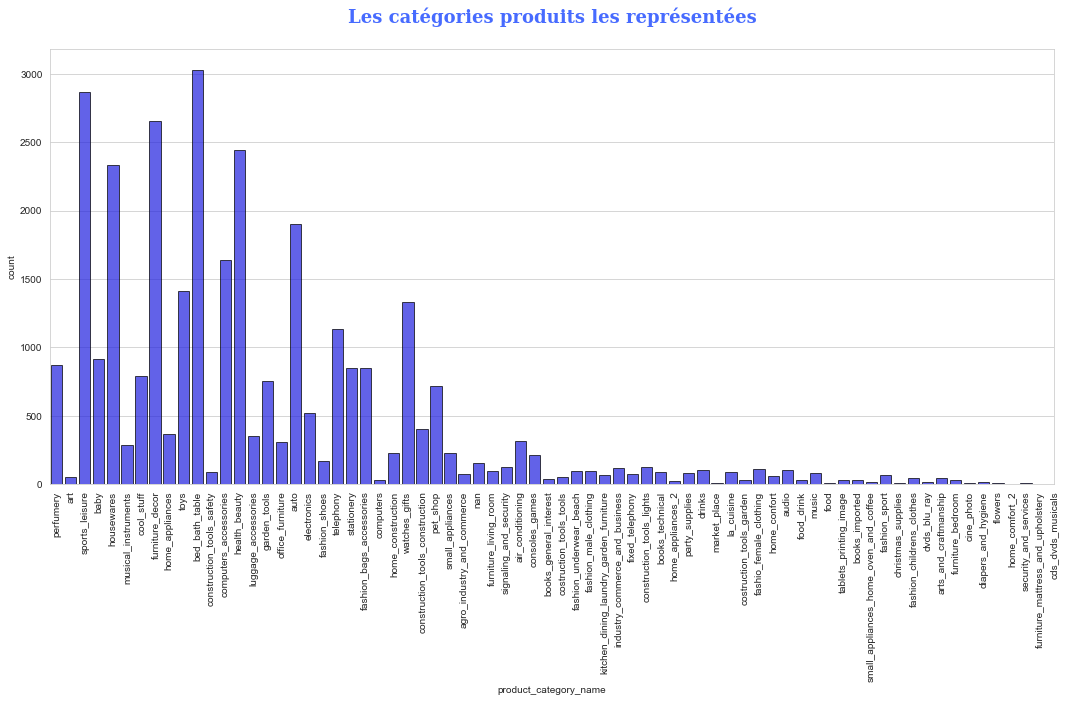

In [14]:
sns.set_style('whitegrid')
font_title = {"family": "serif",
              "color":  "#476bff",
              "weight": "bold",
              "size": 18}

fig = plt.figure(figsize=(18 ,8))
sns.countplot(data=products,x='product_category_name',
        edgecolor = 'black',color='blue',alpha=0.7)

plt.xticks(range(0,products['product_category_name'].nunique()+1),products["product_category_name"].unique(),rotation=90)

plt.title(f"Les catégories produits les représentées\n",fontdict=font_title)

plt.show()

Joiture : Clients et Commandes : 

Nous allons cette fois-ci regrouper les données de clients, de lignes de commandes et d'en-têtes de commandes dans un seul dataframe . 

In [15]:
order_items = pd.merge(df_order,df_odataset,how='left',on='order_id')

In [16]:
# Supprision des feautures non nécessaire

del_features_list2 = ["seller_id","shipping_limit_date","order_approved_at","order_delivered_carrier_date","order_estimated_delivery_date"]

order_items.drop(del_features_list2,axis=1,inplace=True)


In [17]:
order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_status order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a    delivered      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce    delivered      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3    delivered      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06    delivered      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795    delivered      2017-02-04 13:57:51   

  order_delivered_customer_date  
0           2017-09-20 23:43:48  
1           2017-05-12 16:04:24  
2           2018-01-22 13:19:16  
3           2018-08-14 13:32:39  
4           2017-03-01 16:42:31

In [18]:
# Observation des status des commandes :

order_items.groupby(by="order_status").sum()["order_item_id"]

order_status
approved            4
canceled          704
delivered      132036
invoiced          435
processing        455
shipped          1294
unavailable         8
Name: order_item_id, dtype: int64

In [19]:
# Idée du pourcentage par statut des commandes
Statuts = order_items.groupby('order_status')['order_id'].count()
df_statuts = pd.DataFrame({'Type de statut': Statuts.index,
                           'Nb_par_statuts': Statuts.values})
nb_tot = df_statuts['Nb_par_statuts'].sum()
df_statuts['%'] = round((df_statuts['Nb_par_statuts']*100)/nb_tot, 3)
df_statuts.sort_values(by='%', ascending=False)

Type de statut  Nb_par_statuts       %
2      delivered          110197  97.822
5        shipped            1185   1.052
1       canceled             542   0.481
3       invoiced             359   0.319
4     processing             357   0.317
6    unavailable               7   0.006
0       approved               3   0.003

Remarque:

- 97 % des colis sont délivrées 

Ici , ce sont seulement les commandes délivrer qui vont nous intéresser. 

In [20]:
order_items = order_items[order_items["order_status"] == "delivered"]

In [21]:
order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_status order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a    delivered      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce    delivered      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3    delivered      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06    delivered      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795    delivered      2017-02-04 13:57:51   

  order_delivered_customer_date  
0           2017-09-20 23:43:48  
1           2017-05-12 16:04:24  
2           2018-01-22 13:19:16  
3           2018-08-14 13:32:39  
4           2017-03-01 16:42:31

Evolution du nombre de commande passées par jour sur le site E-commerce :

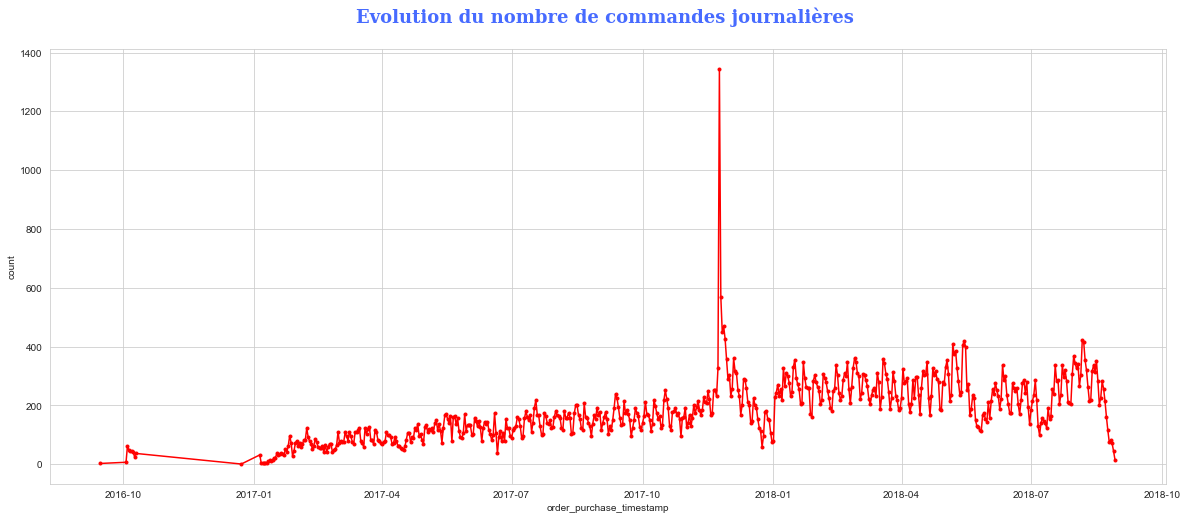

In [22]:

orders_per_days = order_items.groupby(order_items['order_purchase_timestamp']\
                            .astype("datetime64[ns]").dt.date)\
                            .count()["order_id"]

fig = plt.figure(figsize=(20, 8))
ax = orders_per_days.plot(color='red',marker='.')
ax.set_ylabel("count")
plt.title(f"Evolution du nombre de commandes journalières \n",fontdict = font_title)

plt.show()

Remarque : 

- un pic d'activité observable aux alentour du mois novembre-décembre (2017) : probablement dû à la période de Noël, de même que la période de calme précédente ce pic d'activité.
- manque de donnée : entre 2016 et début 2017

Modification des types de données en datetime pour les colonnes temporelles

In [23]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 112649
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       110197 non-null  object 
 1   order_item_id                  110197 non-null  int64  
 2   product_id                     110197 non-null  object 
 3   price                          110197 non-null  float64
 4   freight_value                  110197 non-null  float64
 5   customer_id                    110197 non-null  object 
 6   order_status                   110197 non-null  object 
 7   order_purchase_timestamp       110197 non-null  object 
 8   order_delivered_customer_date  110189 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 8.4+ MB


In [24]:
#Changement - Timestamps : 

from datetime import datetime


datetime_cols = ['order_purchase_timestamp',"order_delivered_customer_date"]

for col in datetime_cols :
    order_items[col] = order_items[col].astype('datetime64[ns]')

order_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 112649
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   order_item_id                  110197 non-null  int64         
 2   product_id                     110197 non-null  object        
 3   price                          110197 non-null  float64       
 4   freight_value                  110197 non-null  float64       
 5   customer_id                    110197 non-null  object        
 6   order_status                   110197 non-null  object        
 7   order_purchase_timestamp       110197 non-null  datetime64[ns]
 8   order_delivered_customer_date  110189 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 8.4+ MB


Répartition du nombre de commandes selon les mois, jours de la semaine ou heure de la journée :

In [25]:
order_items.groupby(order_items['order_purchase_timestamp'].dt.month)\
                   .agg({"order_id":"nunique"})

order_id
order_purchase_timestamp          
1                             7819
2                             8208
3                             9549
4                             9101
5                            10295
6                             9234
7                            10031
8                            10544
9                             4151
10                            4743
11                            7289
12                            5514

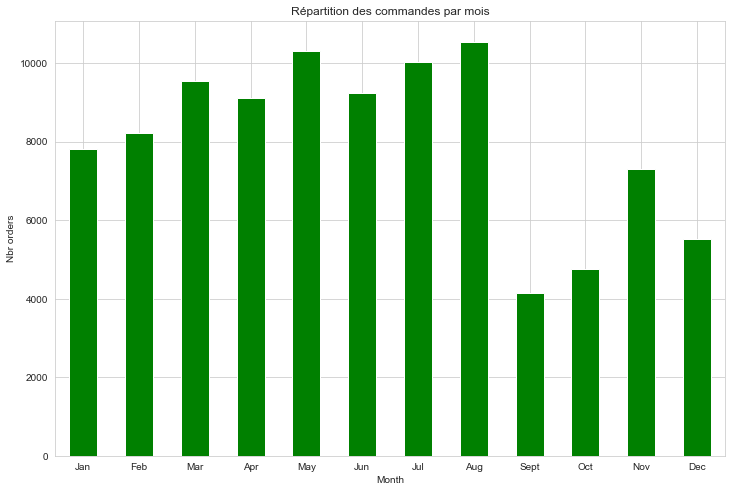

In [26]:
order_items.groupby(order_items['order_purchase_timestamp'].dt.month)\
                   .agg({"order_id":"nunique"})\
                   .plot(figsize=(12, 8),kind='bar',title="Répartition des commandes par mois",
                   ylabel="Nbr orders",
                   xlabel="Month",
                   color = 'green',
                   legend= False)
plt.xticks(np.arange(0,12),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'],rotation='horizontal')

plt.show()

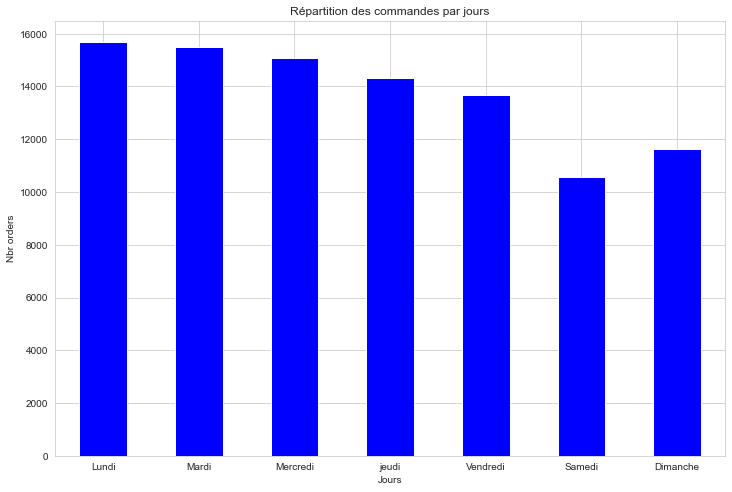

In [27]:
order_items.groupby(order_items['order_purchase_timestamp'].dt.dayofweek)\
                   .agg({"order_id":"nunique"})\
                   .plot(figsize=(12, 8),kind='bar',title="Répartition des commandes par jours",
                   ylabel="Nbr orders",
                   xlabel="Jours",
                   color = 'blue',
                   legend= False)
plt.xticks(np.arange(0,7),['Lundi','Mardi','Mercredi','jeudi','Vendredi','Samedi','Dimanche'],rotation='horizontal')

plt.show()

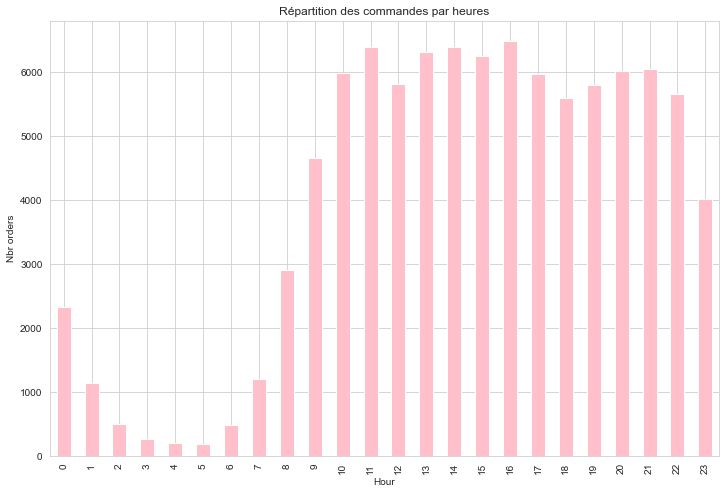

In [28]:
order_items.groupby(order_items['order_purchase_timestamp'].dt.hour)\
                   .agg({"order_id":"nunique"})\
                   .plot(figsize=(12, 8),kind='bar',title="Répartition des commandes par heures",
                   ylabel="Nbr orders",
                   xlabel="Hour",
                   color = 'pink',
                   legend= False)

plt.show()

Remarque : 

- Les données mensuelles et journalières semblent être les plus parlants. 
- Nous pouvons vérifier les variances des chiffres d'affaires. 

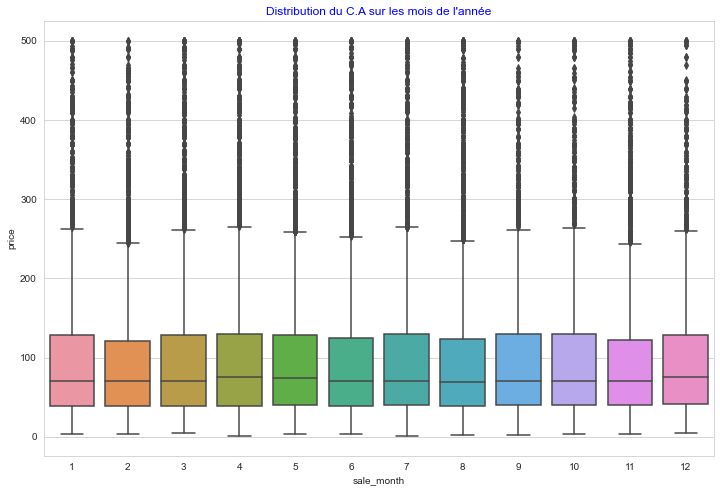

In [29]:
order_items["sale_month"] = order_items["order_purchase_timestamp"].dt.month

fig = plt.figure(figsize=(12,8))
sns.boxplot(data=order_items[order_items.price<500],x="sale_month",y="price")
plt.title("Distribution du C.A sur les mois de l'année",color='b')

plt.show()

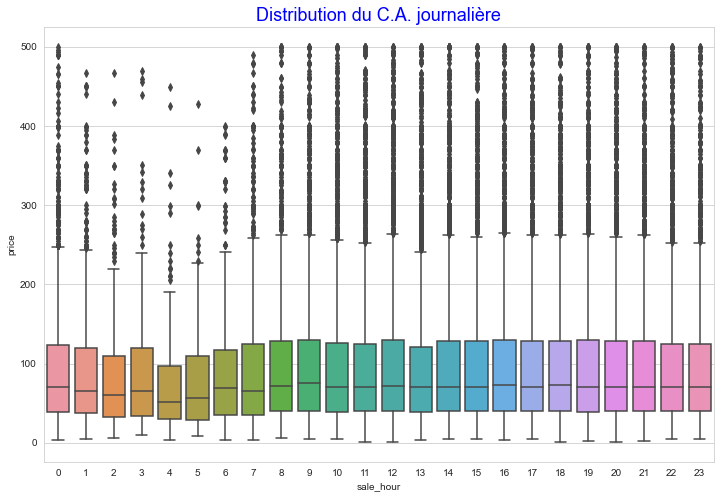

In [30]:
order_items["sale_hour"] = order_items['order_purchase_timestamp'].dt.hour
fig = plt.figure(figsize=(12,8))
sns.boxplot(data=order_items[order_items.price < 500], x="sale_hour", y="price")
plt.title("Distribution du C.A. journalière", fontsize=18, color="b")
plt.show()

Remarque : 

- Les médianes et variances restent proches les unes des autres globalement que ça soit sur les différents mois ou les heures journalières. 

Création de nouvelle features pour le datasets des paiements :

    - Nombre de paiements différents utilisés pour une commande
    - Nombre d'échéances par commande

In [31]:
#création des deux features : Nbr de moyens de paimenet :"nb_payment_sequential" | nombre total d'échéance:"sum_payment_installments"
group_payments = df_opayments.groupby(by="order_id").agg({"payment_sequential":"count",
                                                            "payment_installments":"sum"})

order_items = pd.merge(order_items,group_payments,how="left",on="order_id")

order_items = order_items.rename(columns={"payment_sequential":"nb_payment_sequential",
                                          "payment_installments":"sum_payments_installments"})

order_items.head()



order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_status order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a    delivered      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce    delivered      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3    delivered      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06    delivered      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795    delivered      2017-02-04 13:57:51   

  order_delivered_customer_date  sale_month  sale_hour  nb_payment_sequential  \
0           2017-09-20 23:43:48           9          8                    1.0   
1           2017-05-12 16:04:24           4         10                    1.0   
2           2018-01-22 13:19:16           1         14                    1.0   
3           2018-08-14 13:32:39           8         10                    1.0   
4           2017-03-01 16:42:31           2         13                    1.0   

   sum_payments_installments  
0                        2.0  
1                        3.0  
2                        5.0  
3                        2.0  
4                        3.0

Répartition des moyens de paiments utilisés  :

Text(0.5, 1.0, 'Les types de paiements utilisés sur le site')

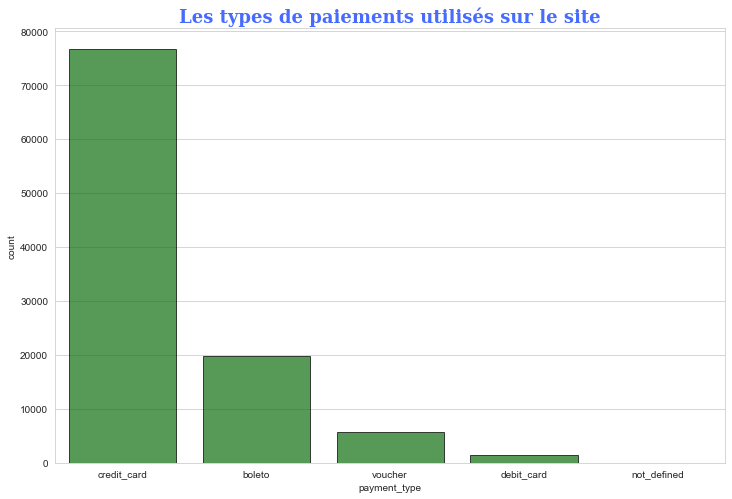

In [32]:
fig = plt.figure(figsize=(12, 8))

sns.countplot(data=df_opayments,x="payment_type",edgecolor="black",color="green",alpha=0.7)

plt.title(f"Les types de paiements utilisés sur le site",fontdict=font_title)

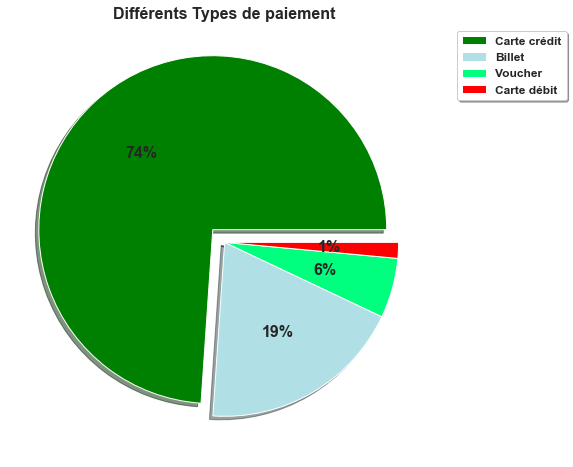

In [33]:
# Pieplot - répartition des différents mode de paiements

fig, ax = plt.subplots(figsize=(9, 8), subplot_kw=dict(aspect='equal'))
explode = (0.1, 0, 0, 0)
colors = ['Green', 'PowderBlue', 'SpringGreen', 'Red']
legend = ['Carte crédit', 'Billet', 'Voucher',
          'Carte débit']

p = df_opayments['payment_type'][df_opayments['payment_type']
                                != 'not_defined'].value_counts()
p.plot(kind="pie", legend=False, labels=None, startangle=0,
       explode=explode, autopct='%1.0f%%', pctdistance=0.6, shadow=True,
       textprops={'weight': 'bold', 'fontsize': 16}, colors=colors,
       ax=ax)
ax.legend(legend, loc='best', shadow=True,
          prop={'weight': 'bold', 'size': 12},
          bbox_to_anchor=(0.8, 0, 0.5, 1))
plt.title('Différents Types de paiement', fontweight='bold', size=16)
plt.ylabel("")
plt.show()

Remarque : 

- 74 % des paiments sont réalisés par carte bancaire 

In [34]:
# Violinplot des paiements en plusieurs fois
import plotly.express as px
# ----------------------------------------------------------------------
fig = px.violin(df_opayments, x='payment_installments')

fig.update_layout(title={'text': 'Paiements en plusieurs fois',
                         'y': 0.9,
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  xaxis=dict(title='Nombre',
                             linecolor="#CCC",
                             showgrid=True),
                  yaxis=dict(title='Paiements en plusieurs fois',
                             linecolor="#CCC",
                             showgrid=True),
                  plot_bgcolor="#FFF")

fig.update_traces(marker_color='SteelBlue')

fig.show()

Remarque : 

- La plupart des commandes sont payées en plusieurs en fois 

Pour les avis clients : création des variables :

    - Si oui ou non la commande a été notée
    - La note attribuée à celle-ci,si OUI  . 

In [35]:
#Création des features : Les commandes notées et leurs notes
group_reviews = df_oreview.groupby("order_id").agg({"review_id":"count",
                                                    "review_score":"mean"})

order_items = pd.merge(order_items,group_reviews,how="left",on="order_id")

order_items = order_items.rename(columns={"review_id":"Reviewed"})

order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_status order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a    delivered      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce    delivered      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3    delivered      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06    delivered      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795    delivered      2017-02-04 13:57:51   

  order_delivered_customer_date  sale_month  sale_hour  nb_payment_sequential  \
0           2017-09-20 23:43:48           9          8                    1.0   
1           2017-05-12 16:04:24           4         10                    1.0   
2           2018-01-22 13:19:16           1         14                    1.0   
3           2018-08-14 13:32:39           8         10                    1.0   
4           2017-03-01 16:42:31           2         13                    1.0   

   sum_payments_installments  Reviewed  review_score  
0                        2.0       1.0           5.0  
1                        3.0       1.0           4.0  
2                        5.0       1.0           5.0  
3                        2.0       1.0           4.0  
4                        3.0       1.0           5.0

In [36]:
# True : si la commande à été noté ,False sinon :
order_items["Reviewed"] = np.where(order_items["Reviewed"] == 1, True,False)

In [37]:
order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_status order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a    delivered      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce    delivered      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3    delivered      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06    delivered      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795    delivered      2017-02-04 13:57:51   

  order_delivered_customer_date  sale_month  sale_hour  nb_payment_sequential  \
0           2017-09-20 23:43:48           9          8                    1.0   
1           2017-05-12 16:04:24           4         10                    1.0   
2           2018-01-22 13:19:16           1         14                    1.0   
3           2018-08-14 13:32:39           8         10                    1.0   
4           2017-03-01 16:42:31           2         13                    1.0   

   sum_payments_installments  Reviewed  review_score  
0                        2.0      True           5.0  
1                        3.0      True           4.0  
2                        5.0      True           5.0  
3                        2.0      True           4.0  
4                        3.0      True           5.0

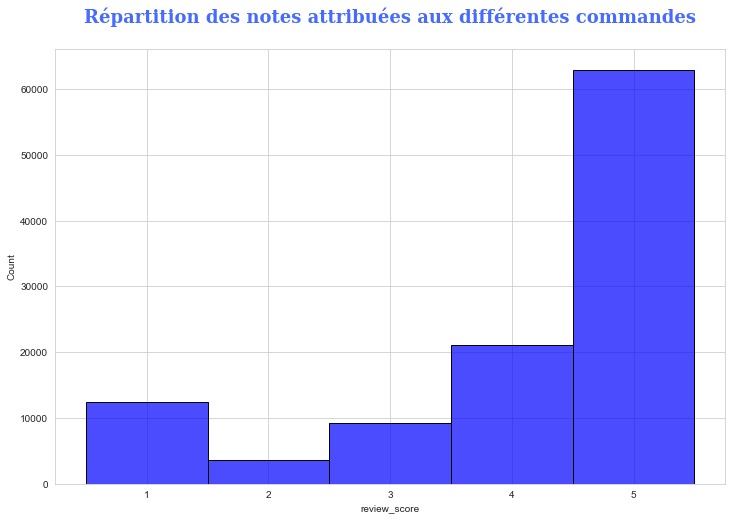

In [38]:
#Répartition des notes attribuées aux commandes :

fig = plt.figure(figsize=(12, 8))

sns.histplot(data=order_items,x="review_score",discrete=True,edgecolor='Black',color='b',alpha=0.7)
plt.title(f"Répartition des notes attribuées aux différentes commandes\n",fontdict=font_title)

plt.show()

In [39]:
# Moyenne des avis des clients ?
moy_notes_avis = round(df_oreview['review_score'].mean(), 2)
print(f'Moyenne des notes des avis des clients : {moy_notes_avis}')

Moyenne des notes des avis des clients : 4.09


Remarque : 

- La plupart des commandes ont une très bonne notes comprise entre 4 et 5 . 

In [40]:
#Jointure des fichiers clients : 

order_items = pd.merge(order_items,df_customers,how="left",on="customer_id")

order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_status order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a    delivered      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce    delivered      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3    delivered      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06    delivered      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795    delivered      2017-02-04 13:57:51   

  order_delivered_customer_date  sale_month  sale_hour  nb_payment_sequential  \
0           2017-09-20 23:43:48           9          8                    1.0   
1           2017-05-12 16:04:24           4         10                    1.0   
2           2018-01-22 13:19:16           1         14                    1.0   
3           2018-08-14 13:32:39           8         10                    1.0   
4           2017-03-01 16:42:31           2         13                    1.0   

   sum_payments_installments  Reviewed  review_score  \
0                        2.0      True           5.0   
1                        3.0      True           4.0   
2                        5.0      True           5.0   
3                        2.0      True           4.0   
4                        3.0      True           5.0   

                 customer_unique_id  customer_zip_code_prefix  \
0  871766c5855e863f6eccc05f988b23cb                     28013   
1  eb28e67c4c0b83846050ddfb8a35d051                     15775   
2  3818d81c6709e39d06b2738a8d3a2474                     35661   
3  af861d436cfc08b2c2ddefd0ba074622                     12952   
4  64b576fb70d441e8f1b2d7d446e483c5                     13226   

           customer_city customer_state  
0  campos dos goytacazes             RJ  
1        santa fe do sul             SP  
2          para de minas             MG  
3                atibaia             SP  
4        varzea paulista             SP

In [41]:
#Suppression des feautures : sale_hours,sale_hours = moins pertinentes
#del_features_list3 = ["sale_hours","sale_hour"]
#order_items.drop(del_features_list3,axis=1,inplace=True)
#
#order_items.head()

Création du dataset final en réalisant le dernier jointre entre "Produit" et "Catégorie" :

In [42]:
data_final = pd.merge(order_items,products,how='left',on="product_id")

data_final.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_status order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a    delivered      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce    delivered      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3    delivered      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06    delivered      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795    delivered      2017-02-04 13:57:51   

  order_delivered_customer_date  sale_month  ...  Reviewed  review_score  \
0           2017-09-20 23:43:48           9  ...      True           5.0   
1           2017-05-12 16:04:24           4  ...      True           4.0   
2           2018-01-22 13:19:16           1  ...      True           5.0   
3           2018-08-14 13:32:39           8  ...      True           4.0   
4           2017-03-01 16:42:31           2  ...      True           5.0   

                 customer_unique_id  customer_zip_code_prefix  \
0  871766c5855e863f6eccc05f988b23cb                     28013   
1  eb28e67c4c0b83846050ddfb8a35d051                     15775   
2  3818d81c6709e39d06b2738a8d3a2474                     35661   
3  af861d436cfc08b2c2ddefd0ba074622                     12952   
4  64b576fb70d441e8f1b2d7d446e483c5                     13226   

           customer_city customer_state  product_name_lenght  \
0  campos dos goytacazes             RJ                 58.0   
1        santa fe do sul             SP                 56.0   
2          para de minas             MG                 59.0   
3                atibaia             SP                 42.0   
4        varzea paulista             SP                 59.0   

  product_description_lenght product_photos_qty  product_category_name  
0                      598.0                4.0             cool_stuff  
1                      239.0                2.0               pet_shop  
2                      695.0                2.0        furniture_decor  
3                      480.0                1.0              perfumery  
4                      409.0                1.0           garden_tools  

[5 rows x 23 columns]

In [43]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 110196
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   order_item_id                  110197 non-null  int64         
 2   product_id                     110197 non-null  object        
 3   price                          110197 non-null  float64       
 4   freight_value                  110197 non-null  float64       
 5   customer_id                    110197 non-null  object        
 6   order_status                   110197 non-null  object        
 7   order_purchase_timestamp       110197 non-null  datetime64[ns]
 8   order_delivered_customer_date  110189 non-null  datetime64[ns]
 9   sale_month                     110197 non-null  int64         
 10  sale_hour                      110197 non-null  int64         
 11  

# 2) Feature Engineering

Les 3 indicateurs [RFM](https://openclassrooms.com/fr/courses/4762856-analysez-des-donnees-marketing) : 

- Une des techniques de segmentation très utilisée en marketing et relativement simple à effectuer est la RFM - <strong>Récence, Fréquence, Montant</strong>.

    <strong>La récence</strong> permet de situer le dernier achat dans le temps. En effet, plus ce celui-ci sera éloigné et moindre sera la valeur de ce client pour vous. Par exemple, un client dont la dernière date d’achat remonte à la semaine dernière aura plus de chance de revenir à votre enseigne qu’un client dont la dernière date d’achat remonte à l’année dernière.

    <strong>La fréquence</strong> indique le nombre de fois où votre client a fait une transaction pendant une période donnée. Plus celle-ci est élevée, plus élevée sera la valeur de ce client pour vous.

    Enfin, <strong>le montant</strong> correspond à la somme ou moyenne des dépenses de votre client. Encore une fois, plus il est élevé, mieux c’est.



Ce type de segmentation est très utile pour faire des ciblages de fidélisation ou raisonner en probabilité d’achat.

L’une des limites de cette segmentation est qu’elle n’est pas figée dans le temps, elle évolue constamment.

Nous allons maintenant nous focaliser sur le côté clients en créant de nouvelle features notamment : " customer_unique_id" (l'id unique de chaque clients)

 - le délai livraison de chaque commande

 - Catégories des produits (groupe) 

In [44]:

data_final["delivery_days"] = (data_final.order_delivered_customer_date - data_final.order_purchase_timestamp).dt.round('1d').dt.days



In [45]:
data_final.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_status order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a    delivered      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce    delivered      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3    delivered      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06    delivered      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795    delivered      2017-02-04 13:57:51   

  order_delivered_customer_date  sale_month  ...  review_score  \
0           2017-09-20 23:43:48           9  ...           5.0   
1           2017-05-12 16:04:24           4  ...           4.0   
2           2018-01-22 13:19:16           1  ...           5.0   
3           2018-08-14 13:32:39           8  ...           4.0   
4           2017-03-01 16:42:31           2  ...           5.0   

                 customer_unique_id  customer_zip_code_prefix  \
0  871766c5855e863f6eccc05f988b23cb                     28013   
1  eb28e67c4c0b83846050ddfb8a35d051                     15775   
2  3818d81c6709e39d06b2738a8d3a2474                     35661   
3  af861d436cfc08b2c2ddefd0ba074622                     12952   
4  64b576fb70d441e8f1b2d7d446e483c5                     13226   

           customer_city  customer_state product_name_lenght  \
0  campos dos goytacazes              RJ                58.0   
1        santa fe do sul              SP                56.0   
2          para de minas              MG                59.0   
3                atibaia              SP                42.0   
4        varzea paulista              SP                59.0   

   product_description_lenght product_photos_qty product_category_name  \
0                       598.0                4.0            cool_stuff   
1                       239.0                2.0              pet_shop   
2                       695.0                2.0       furniture_decor   
3                       480.0                1.0             perfumery   
4                       409.0                1.0          garden_tools   

   delivery_days  
0            8.0  
1           16.0  
2            8.0  
3            6.0  
4           25.0  

[5 rows x 24 columns]

In [46]:
data_final.drop("order_delivered_customer_date",axis=1,inplace=True)

In [47]:
data_final.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_status order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a    delivered      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce    delivered      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3    delivered      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06    delivered      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795    delivered      2017-02-04 13:57:51   

   sale_month  sale_hour  ...  review_score                customer_unique_id  \
0           9          8  ...           5.0  871766c5855e863f6eccc05f988b23cb   
1           4         10  ...           4.0  eb28e67c4c0b83846050ddfb8a35d051   
2           1         14  ...           5.0  3818d81c6709e39d06b2738a8d3a2474   
3           8         10  ...           4.0  af861d436cfc08b2c2ddefd0ba074622   
4           2         13  ...           5.0  64b576fb70d441e8f1b2d7d446e483c5   

   customer_zip_code_prefix          customer_city customer_state  \
0                     28013  campos dos goytacazes             RJ   
1                     15775        santa fe do sul             SP   
2                     35661          para de minas             MG   
3                     12952                atibaia             SP   
4                     13226        varzea paulista             SP   

   product_name_lenght product_description_lenght product_photos_qty  \
0                 58.0                      598.0                4.0   
1                 56.0                      239.0                2.0   
2                 59.0                      695.0                2.0   
3                 42.0                      480.0                1.0   
4                 59.0                      409.0                1.0   

   product_category_name  delivery_days  
0             cool_stuff            8.0  
1               pet_shop           16.0  
2        furniture_decor            8.0  
3              perfumery            6.0  
4           garden_tools           25.0  

[5 rows x 23 columns]

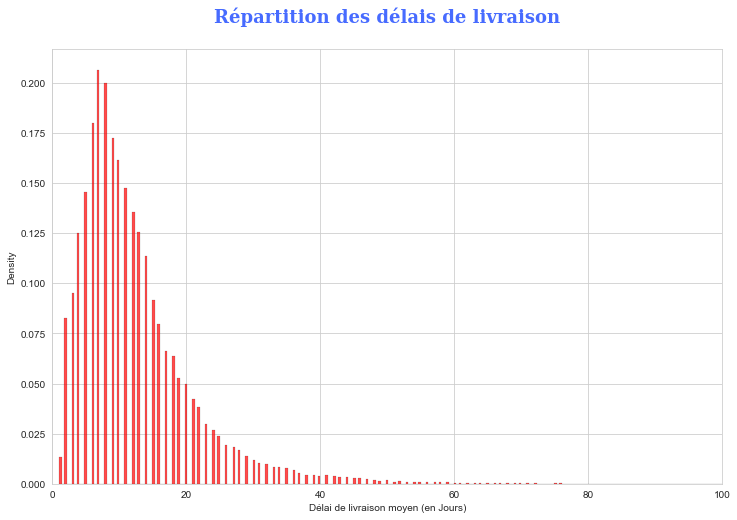

In [48]:
#Répartition des délais de livraison :

fig = plt.figure(figsize=(12,8))
sns.histplot(data=data_final,x="delivery_days",
                    stat = 'density',
                    edgecolor='black',
                    color='red',
                    alpha=0.7)
plt.xlim(0,100)
plt.xlabel("Délai de livraison moyen (en Jours)")
plt.title(f"Répartition des délais de livraison\n",fontdict=font_title)

plt.show()

Remarque : 

- La plupart des produits sont livrées en moins de 20 jours. 

In [49]:
order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'price', 'freight_value',
       'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_delivered_customer_date', 'sale_month', 'sale_hour',
       'nb_payment_sequential', 'sum_payments_installments', 'Reviewed',
       'review_score', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [50]:
#Nombre produit dans la variable catégories 
data_final["product_category_name"].unique()

array(['cool_stuff', 'pet_shop', 'furniture_decor', 'perfumery',
       'garden_tools', 'housewares', 'telephony', 'health_beauty',
       'books_technical', 'fashion_bags_accessories', 'bed_bath_table',
       'sports_leisure', 'consoles_games', 'office_furniture',
       'luggage_accessories', 'food', 'agro_industry_and_commerce',
       'electronics', 'computers_accessories',
       'construction_tools_construction', 'audio', 'baby',
       'construction_tools_lights', 'toys', 'stationery',
       'industry_commerce_and_business', 'watches_gifts', 'auto', nan,
       'home_appliances', 'kitchen_dining_laundry_garden_furniture',
       'air_conditioning', 'home_confort', 'fixed_telephony',
       'small_appliances_home_oven_and_coffee', 'diapers_and_hygiene',
       'signaling_and_security', 'musical_instruments',
       'small_appliances', 'costruction_tools_garden', 'art',
       'home_construction', 'books_general_interest', 'party_supplies',
       'construction_tools_safety', 'c

FE: Catégories des produits (groupe) :

Nous pouvons remarquer qu'il y a énorméments de produit différents contenue dans la variables "product_category_name" , ce qui peut devenir problématique pour la suite de notre projet !

- l'idée serai de les regrouper en sous-groupe plus "explicative et pertinent" . 

Or le selon les [statistques](https://www.statista.com/) issue des mondial les catégories des produits vendus sur les sites [e-commerce](https://www.tidio.com/blog/online-shopping-statistics/#male-vs-female-shopping-statistics) sont : 

    * Fashion, clothing and accessories (vêtements)
    * Health and Beauty (santé et beauté)
    * Toys and baby equipment (jouets)
    * Books, CDs and other physical media (multimédia)
    * Groceries, food and drink (nourriture)
    * Technology (including phones and computers) (Technologie)
    * Home and furniture (fourniture | maison)
    * Flowers and gifts (cadeau et fleurs)
    * Sport (éléments sportifs)
    * and Other
     

In [51]:
#Nous ajouter les différents catégories :

data_final['product_category'] = np.where((data_final['product_category_name'].str.contains("fashio|luggage")==True),
                                    'fashion_clothing_accessories',
                           np.where((data_final['product_category_name'].str.contains("health|beauty|perfum")==True),
                                    'health_beauty',
                           np.where((data_final['product_category_name'].str.contains("toy|baby|diaper")==True),
                                     'toys_baby',
                           np.where((data_final['product_category_name'].str.contains("book|cd|dvd|media")==True),
                                     'books_cds_media',
                           np.where((data_final['product_category_name'].str.contains("grocer|food|drink")==True), 
                                     'groceries_food_drink',
                           np.where((data_final['product_category_name'].str.contains("phon|compu|tablet|electro|consol")==True), 
                                     'technology',
                           np.where((data_final['product_category_name'].str.contains("home|furnitur|garden|bath|house|applianc")==True), 
                                                                                          'home_furniture',
                           np.where((data_final['product_category_name'].str.contains("flow|gift|stuff")==True),
                                     'flowers_gifts',
                           np.where((data_final['product_category_name'].str.contains("sport")==True),
                                     'sport',
                                     'other')))))))))

In [52]:
data_final.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_status order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a    delivered      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce    delivered      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3    delivered      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06    delivered      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795    delivered      2017-02-04 13:57:51   

   sale_month  sale_hour  ...                customer_unique_id  \
0           9          8  ...  871766c5855e863f6eccc05f988b23cb   
1           4         10  ...  eb28e67c4c0b83846050ddfb8a35d051   
2           1         14  ...  3818d81c6709e39d06b2738a8d3a2474   
3           8         10  ...  af861d436cfc08b2c2ddefd0ba074622   
4           2         13  ...  64b576fb70d441e8f1b2d7d446e483c5   

   customer_zip_code_prefix          customer_city  customer_state  \
0                     28013  campos dos goytacazes              RJ   
1                     15775        santa fe do sul              SP   
2                     35661          para de minas              MG   
3                     12952                atibaia              SP   
4                     13226        varzea paulista              SP   

  product_name_lenght  product_description_lenght product_photos_qty  \
0                58.0                       598.0                4.0   
1                56.0                       239.0                2.0   
2                59.0                       695.0                2.0   
3                42.0                       480.0                1.0   
4                59.0                       409.0                1.0   

  product_category_name  delivery_days  product_category  
0            cool_stuff            8.0     flowers_gifts  
1              pet_shop           16.0             other  
2       furniture_decor            8.0    home_furniture  
3             perfumery            6.0     health_beauty  
4          garden_tools           25.0    home_furniture  

[5 rows x 24 columns]

In [53]:
# Suprresion de la colonne "product_category_name" :

data_final.drop("product_category_name",axis=1,inplace=True)

In [54]:
data_final.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id   price  freight_value  \
0  4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1  e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2  c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3  7634da152a4610f1595efa32f14722fc   12.99          12.79   
4  ac6c3623068f30de03045865e4e10089  199.90          18.14   

                        customer_id order_status order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a    delivered      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce    delivered      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3    delivered      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06    delivered      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795    delivered      2017-02-04 13:57:51   

   sale_month  sale_hour  ...  review_score                customer_unique_id  \
0           9          8  ...           5.0  871766c5855e863f6eccc05f988b23cb   
1           4         10  ...           4.0  eb28e67c4c0b83846050ddfb8a35d051   
2           1         14  ...           5.0  3818d81c6709e39d06b2738a8d3a2474   
3           8         10  ...           4.0  af861d436cfc08b2c2ddefd0ba074622   
4           2         13  ...           5.0  64b576fb70d441e8f1b2d7d446e483c5   

   customer_zip_code_prefix          customer_city customer_state  \
0                     28013  campos dos goytacazes             RJ   
1                     15775        santa fe do sul             SP   
2                     35661          para de minas             MG   
3                     12952                atibaia             SP   
4                     13226        varzea paulista             SP   

   product_name_lenght product_description_lenght product_photos_qty  \
0                 58.0                      598.0                4.0   
1                 56.0                      239.0                2.0   
2                 59.0                      695.0                2.0   
3                 42.0                      480.0                1.0   
4                 59.0                      409.0                1.0   

   delivery_days  product_category  
0            8.0     flowers_gifts  
1           16.0             other  
2            8.0    home_furniture  
3            6.0     health_beauty  
4           25.0    home_furniture  

[5 rows x 23 columns]

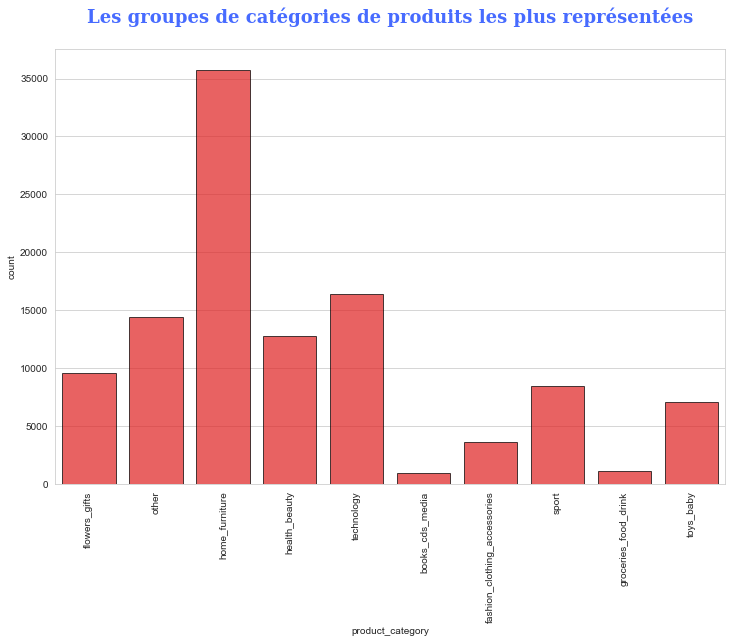

In [55]:
# Catégorie des produits les plus réprésentées :

fig = plt.figure(figsize=(12, 8))
sns.countplot(data=data_final,
             x="product_category",
             edgecolor='black',
             color='r',
             alpha=0.7)
plt.xticks(range(0,data_final["product_category"].nunique()),
                   data_final["product_category"].unique(), rotation=90)

plt.title(f"Les groupes de catégories de produits les plus représentées\n",fontdict=font_title)

plt.show()

In [56]:
# Pieplot de représentation des catégories de produits
def trace_pieplot(dataframe, variable, titre, legende, liste_colors):
    """
    Suivi des dipsersions : bosplot et qqplot
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                variable : colonne dont on veut voir les outliers (str)
                titre :titre pour les graphiques (str)
                legende : titre de la légende
                liste_colors : liste des couleurs
    @param OUT :None
    """

    plt.figure(figsize=(16, 12))
    plt.title(titre, size=16)
    nb_par_var = dataframe[variable].sort_values().value_counts()
    # nb_par_var = nb_par_var.loc[sorted(nb_par_var.index)]
    explode = [0.1]
    for i in range(len(nb_par_var) - 1):
        explode.append(0)
    wedges, texts, autotexts = plt.pie(
        nb_par_var, labels=nb_par_var.index, autopct='%1.1f%%', colors=liste_colors, textprops={
            'fontsize': 12, 'color': 'black', 'backgroundcolor': 'w'}, explode = explode)
    axes = plt.gca()
    axes.legend(
        wedges,
        nb_par_var.index,
        title=legende,
        loc='upper right',
        fontsize=12,
        bbox_to_anchor=(    #Emplacement de la légende
            1,
            0,
            0.5,
            1) ) # <= à vérifier loc=upper right
    plt.show()

In [57]:
data_final.columns

Index(['order_id', 'order_item_id', 'product_id', 'price', 'freight_value',
       'customer_id', 'order_status', 'order_purchase_timestamp', 'sale_month',
       'sale_hour', 'nb_payment_sequential', 'sum_payments_installments',
       'Reviewed', 'review_score', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'delivery_days', 'product_category'],
      dtype='object')

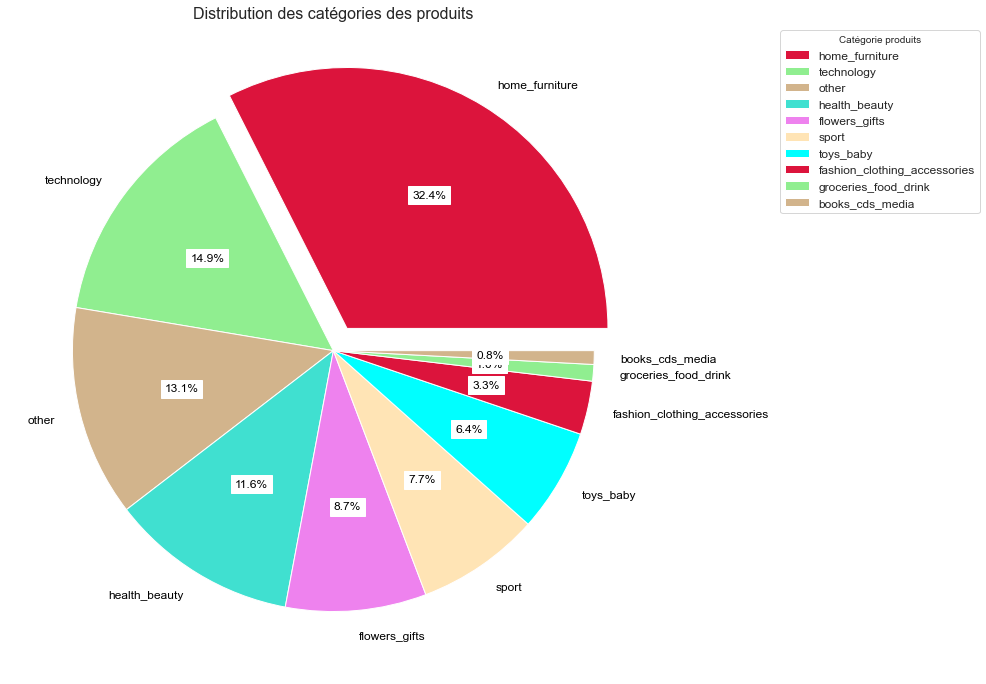

In [58]:
# Pieplot de représentation des catégories de produits
#--------------------------------------------
colors_niveau = ['Crimson', 'LightGreen', 'Tan', 'Turquoise', 'Violet',
                 'Moccasin', 'Aqua']
title = 'Distribution des catégories des produits'
trace_pieplot(data_final, 'product_category',
                          title, 'Catégorie produits', colors_niveau)

Remarque : 

- les groupes de produits, les plus vendues sont :
    * home_fourniture
    * technology
    * other

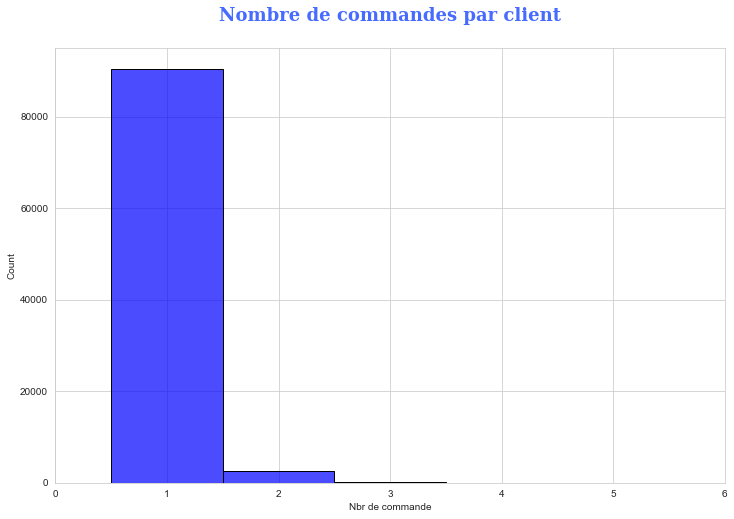

In [59]:
#Nombre de commandes moyen par clients :

fig = plt.figure(figsize=(12, 8))
sns.histplot(data_final.groupby("customer_unique_id").agg({"order_id":"nunique"}),
             x = "order_id",
             discrete = True,
             edgecolor = "black",
             color='b',
             alpha=0.7)
plt.xlim(0,6)
plt.xlabel('Nbr de commande')
plt.title(f"Nombre de commandes par client\n",fontdict=font_title)
plt.show()

Remarque: 

- La majorité des clients ne passe seulement qu'une seule commande . 

In [60]:
# Crée le features par catégorie de produit : 

categories_customers = data_final.groupby(["customer_unique_id", "product_category"])\
                        .agg({"order_item_id": "count"}).unstack()
categories_customers.columns = categories_customers.columns.droplevel(0)
categories_customers.fillna(0, inplace=True)
categories_customers["total_items"] = categories_customers.sum(axis=1)

# Calcule du ratio du nbr de produit par catégorie sur le nbr de produit total acheté par le client
for col in categories_customers.columns:
    if (col != "total_items"):
        categories_customers[col] = (categories_customers[col]/categories_customers["total_items"])

categories_customers.reset_index(inplace=True)
categories_customers.head()

product_category                customer_unique_id  books_cds_media  \
0                 0000366f3b9a7992bf8c76cfdf3221e2              0.0   
1                 0000b849f77a49e4a4ce2b2a4ca5be3f              0.0   
2                 0000f46a3911fa3c0805444483337064              0.0   
3                 0000f6ccb0745a6a4b88665a16c9f078              0.0   
4                 0004aac84e0df4da2b147fca70cf8255              0.0   

product_category  fashion_clothing_accessories  flowers_gifts  \
0                                          0.0            0.0   
1                                          0.0            0.0   
2                                          0.0            0.0   
3                                          0.0            0.0   
4                                          0.0            0.0   

product_category  groceries_food_drink  health_beauty  home_furniture  other  \
0                                  0.0            0.0             1.0    0.0   
1                                  0.0            1.0             0.0    0.0   
2                                  0.0            0.0             0.0    1.0   
3                                  0.0            0.0             0.0    0.0   
4                                  0.0            0.0             0.0    0.0   

product_category  sport  technology  toys_baby  total_items  
0                   0.0         0.0        0.0          1.0  
1                   0.0         0.0        0.0          1.0  
2                   0.0         0.0        0.0          1.0  
3                   0.0         1.0        0.0          1.0  
4                   0.0         1.0        0.0          1.0

Text(0.5, 1.0, "Nombre moyen d'articles par commande\n")

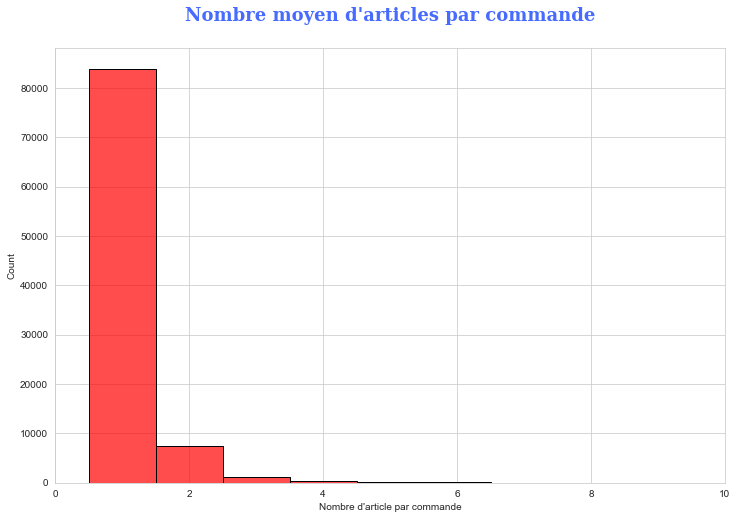

In [61]:
# Calcule du nombre moyen d'article par commande pour chaque client :

products_order = data_final.groupby(["customer_unique_id","order_id"]).agg({"order_item_id":"count"})

products_order = products_order.groupby("customer_unique_id").agg({"order_item_id":"mean"})


#Nombre moyen d'articles par commande: 

fig = plt.figure(figsize=(12,8))
sns.histplot(data=products_order,
             x ="order_item_id" ,
             discrete="True",
             edgecolor="black",
             color='red',
             alpha=0.7)

plt.xlim(0,10)
plt.xlabel("Nombre d'article par commande")
plt.title(f"Nombre moyen d'articles par commande\n",fontdict=font_title)

Remarque : 

- pour chaque commande passer seulement 1 ou 2 articles sera choisi . 

In [62]:
#RFM : La RECENSE est la durée entre une date de référence et la dernière date d'achat client
# Calcule du nombre de jour écoulés entre la première et dernière commande:

#from tkinter.tix import DisplayStyle


Recurencies = data_final.groupby("customer_unique_id").agg({"order_purchase_timestamp":["min","max"]})

Recurencies.columns = Recurencies.columns.droplevel(0)

#Date max :
max_date = data_final["order_purchase_timestamp"].max()

#Délai du dernier livraison : 

Recurencies["order_total_delay"] = [(y[1]-y[0]).round('1d').days if y[1] != y[0]
        else (max_date - y[0]).round('1d')
        for x,y in Recurencies.iterrows()]
#Suppresion des "min" et "max"        
Recurencies.drop(["min","max"],axis=1,inplace=True)

Recurencies.head()

order_total_delay
customer_unique_id                                 
0000366f3b9a7992bf8c76cfdf3221e2  111 days 00:00:00
0000b849f77a49e4a4ce2b2a4ca5be3f  114 days 00:00:00
0000f46a3911fa3c0805444483337064  537 days 00:00:00
0000f6ccb0745a6a4b88665a16c9f078  321 days 00:00:00
0004aac84e0df4da2b147fca70cf8255  288 days 00:00:00

Le dataset Client:

In [63]:
# Customers avec somme et moyenne 
data_final = data_final.groupby("customer_unique_id")\
            .agg({"order_id": "nunique",
                  "price": "sum",
                  "freight_value": "sum",
                  "nb_payment_sequential": "mean", 
                  "sum_payments_installments": "mean", 
                  "review_score": "mean",
                  "delivery_days": "mean",
                  "sale_month": lambda x:x.value_counts().index[0]})

# Rename les colonnes
data_final = data_final.rename(columns={"order_id": "nb_orders",
                            "price": "total_spend",
                            "freight_value": "total_freight",
                            "nb_payment_sequential": "mean_payment_sequential",
                            "sum_payments_installments": "mean_payment_installments",
                            "review_score": "mean_review_score",
                            "delivery_days": "mean_delivery_days",
                            "sale_month": "favorite_sale_month"})

# Merge avec les autres features calculées
data_final = pd.merge(data_final, categories_customers,
                how="left",
                on="customer_unique_id")

data_final = pd.merge(data_final, products_order,
                how="left",
                on="customer_unique_id")\
        .rename(columns={"order_item_id": "mean_nb_items"})

data_final = pd.merge(data_final, Recurencies,
                how="left",
                on="customer_unique_id")

data_final.head()

customer_unique_id  nb_orders  total_spend  total_freight  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1       129.90          12.00   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1        18.90           8.29   
2  0000f46a3911fa3c0805444483337064          1        69.00          17.22   
3  0000f6ccb0745a6a4b88665a16c9f078          1        25.99          17.63   
4  0004aac84e0df4da2b147fca70cf8255          1       180.00          16.89   

   mean_payment_sequential  mean_payment_installments  mean_review_score  \
0                      1.0                        8.0                5.0   
1                      1.0                        1.0                4.0   
2                      1.0                        8.0                3.0   
3                      1.0                        4.0                4.0   
4                      1.0                        6.0                5.0   

   mean_delivery_days  favorite_sale_month  books_cds_media  ...  \
0                 6.0                    5              0.0  ...   
1                 3.0                    5              0.0  ...   
2                26.0                    3              0.0  ...   
3                20.0                   10              0.0  ...   
4                13.0                   11              0.0  ...   

   groceries_food_drink  health_beauty  home_furniture  other  sport  \
0                   0.0            0.0             1.0    0.0    0.0   
1                   0.0            1.0             0.0    0.0    0.0   
2                   0.0            0.0             0.0    1.0    0.0   
3                   0.0            0.0             0.0    0.0    0.0   
4                   0.0            0.0             0.0    0.0    0.0   

   technology  toys_baby  total_items  mean_nb_items  order_total_delay  
0         0.0        0.0          1.0            1.0  111 days 00:00:00  
1         0.0        0.0          1.0            1.0  114 days 00:00:00  
2         0.0        0.0          1.0            1.0  537 days 00:00:00  
3         1.0        0.0          1.0            1.0  321 days 00:00:00  
4         1.0        0.0          1.0            1.0  288 days 00:00:00  

[5 rows x 22 columns]

In [64]:
#le délai moyen entre plusieurs achats :
data_final["order_total_delay"] = data_final["order_total_delay"] / data_final["nb_orders"]
data_final = data_final.rename(columns={"order_total_delay": "order_mean_delay"})

Il nous reste à présent à calculer quelques dernières variables plus représentatives :

- Le ratio fret / total commande = > <strong>"La fréquence"</strong>
- le prix moyen par commande = > <strong> " Le Montant" </strong>

    * N.B : 
    
    <strong>La fréquence </strong>est 'le nombre de fois où votre client a fait une transaction pendant une période donnée' donc le nombre de commandes sur la période de l'étude ;  <br></br>

    <strong>Le montant </strong> correspond à la somme ou moyenne des dépenses de votre client.

In [65]:
data_final["freight_ratio"] = round(data_final["total_freight"] / (data_final["total_spend"] + data_final["total_freight"]),2) #

data_final["mean_price_order"] = round(data_final["total_spend"] / data_final["nb_orders"],2)

data_final["total_spend"] = (data_final["total_spend"] + data_final["total_freight"])

data_final.drop("total_freight", axis=1, inplace=True)

In [66]:
df_customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [67]:
#ajouter les données de localisation des clients :
df_customers.drop("customer_id", axis=1, inplace=True)
# Select the most frequents values for each customer
customers_info = df_customers.groupby("customer_unique_id").agg(lambda x:x.value_counts().index[0])
data_final = pd.merge(data_final, customers_info,
                how="left",
                on="customer_unique_id")

### Exploration 

In [68]:
data_final.head()

customer_unique_id  nb_orders  total_spend  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1       141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1        27.19   
2  0000f46a3911fa3c0805444483337064          1        86.22   
3  0000f6ccb0745a6a4b88665a16c9f078          1        43.62   
4  0004aac84e0df4da2b147fca70cf8255          1       196.89   

   mean_payment_sequential  mean_payment_installments  mean_review_score  \
0                      1.0                        8.0                5.0   
1                      1.0                        1.0                4.0   
2                      1.0                        8.0                3.0   
3                      1.0                        4.0                4.0   
4                      1.0                        6.0                5.0   

   mean_delivery_days  favorite_sale_month  books_cds_media  \
0                 6.0                    5              0.0   
1                 3.0                    5              0.0   
2                26.0                    3              0.0   
3                20.0                   10              0.0   
4                13.0                   11              0.0   

   fashion_clothing_accessories  ...  technology  toys_baby  total_items  \
0                           0.0  ...         0.0        0.0          1.0   
1                           0.0  ...         0.0        0.0          1.0   
2                           0.0  ...         0.0        0.0          1.0   
3                           0.0  ...         1.0        0.0          1.0   
4                           0.0  ...         1.0        0.0          1.0   

   mean_nb_items   order_mean_delay  freight_ratio  mean_price_order  \
0            1.0  111 days 00:00:00           0.08            129.90   
1            1.0  114 days 00:00:00           0.30             18.90   
2            1.0  537 days 00:00:00           0.20             69.00   
3            1.0  321 days 00:00:00           0.40             25.99   
4            1.0  288 days 00:00:00           0.09            180.00   

   customer_zip_code_prefix  customer_city  customer_state  
0                      7787        cajamar              SP  
1                      6053         osasco              SP  
2                     88115       sao jose              SC  
3                     66812          belem              PA  
4                     18040       sorocaba              SP  

[5 rows x 26 columns]

In [69]:
data_final.columns

Index(['customer_unique_id', 'nb_orders', 'total_spend',
       'mean_payment_sequential', 'mean_payment_installments',
       'mean_review_score', 'mean_delivery_days', 'favorite_sale_month',
       'books_cds_media', 'fashion_clothing_accessories', 'flowers_gifts',
       'groceries_food_drink', 'health_beauty', 'home_furniture', 'other',
       'sport', 'technology', 'toys_baby', 'total_items', 'mean_nb_items',
       'order_mean_delay', 'freight_ratio', 'mean_price_order',
       'customer_zip_code_prefix', 'customer_city', 'customer_state'],
      dtype='object')

In [70]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_unique_id            93358 non-null  object 
 1   nb_orders                     93358 non-null  int64  
 2   total_spend                   93358 non-null  float64
 3   mean_payment_sequential       93357 non-null  float64
 4   mean_payment_installments     93357 non-null  float64
 5   mean_review_score             92755 non-null  float64
 6   mean_delivery_days            93350 non-null  float64
 7   favorite_sale_month           93358 non-null  int64  
 8   books_cds_media               93358 non-null  float64
 9   fashion_clothing_accessories  93358 non-null  float64
 10  flowers_gifts                 93358 non-null  float64
 11  groceries_food_drink          93358 non-null  float64
 12  health_beauty                 93358 non-null  float64
 13  h

Remarque: 

- 3 variables contiennent des valeurs nulles.
- Complétons par les valeurs les plus fréquentes :

In [71]:
# Fill and Fillna [mode]:
features_to_fill = data_final.isnull().sum()
features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)

for f in features_to_fill:
    data_final[f] = data_final[f].fillna(data_final[f].mode()[0])
    print(f, data_final[f].mode()[0])

mean_payment_sequential 1.0
mean_payment_installments 1.0
mean_review_score 5.0
mean_delivery_days 7.0


In [72]:
data_final.describe()

nb_orders   total_spend  mean_payment_sequential  \
count  93358.000000  93358.000000             93358.000000   
mean       1.033420    165.168210                 1.043872   
std        0.209097    226.292101                 0.364435   
min        1.000000      9.590000                 1.000000   
25%        1.000000     63.010000                 1.000000   
50%        1.000000    107.780000                 1.000000   
75%        1.000000    182.510000                 1.000000   
max       15.000000  13664.080000                26.000000   

       mean_payment_installments  mean_review_score  mean_delivery_days  \
count               93358.000000       93358.000000        93358.000000   
mean                    2.965951           4.158806           12.524327   
std                     2.717719           1.278290            9.550578   
min                     0.000000           1.000000            1.000000   
25%                     1.000000           4.000000            7.000000   
50%                     2.000000           5.000000           10.000000   
75%                     4.000000           5.000000           16.000000   
max                    26.000000           5.000000          210.000000   

       favorite_sale_month  books_cds_media  fashion_clothing_accessories  \
count         93358.000000     93358.000000                  93358.000000   
mean              6.034759         0.009085                      0.034082   
std               3.226430         0.094527                      0.180035   
min               1.000000         0.000000                      0.000000   
25%               3.000000         0.000000                      0.000000   
50%               6.000000         0.000000                      0.000000   
75%               8.000000         0.000000                      0.000000   
max              12.000000         1.000000                      1.000000   

       flowers_gifts  ...  home_furniture         other         sport  \
count   93358.000000  ...    93358.000000  93358.000000  93358.000000   
mean        0.094412  ...        0.300037      0.133696      0.077026   
std         0.290952  ...        0.455846      0.338181      0.265228   
min         0.000000  ...        0.000000      0.000000      0.000000   
25%         0.000000  ...        0.000000      0.000000      0.000000   
50%         0.000000  ...        0.000000      0.000000      0.000000   
75%         0.000000  ...        1.000000      0.000000      0.000000   
max         1.000000  ...        1.000000      1.000000      1.000000   

         technology     toys_baby   total_items  mean_nb_items  freight_ratio  \
count  93358.000000  93358.000000  93358.000000   93358.000000   93358.000000   
mean       0.152034      0.068452      1.180370       1.139531       0.208141   
std        0.357663      0.251017      0.620857       0.527075       0.124892   
min        0.000000      0.000000      1.000000       1.000000       0.000000   
25%        0.000000      0.000000      1.000000       1.000000       0.120000   
50%        0.000000      0.000000      1.000000       1.000000       0.180000   
75%        0.000000      0.000000      1.000000       1.000000       0.270000   
max        1.000000      1.000000     24.000000      21.000000       0.960000   

       mean_price_order  customer_zip_code_prefix  
count      93358.000000              93358.000000  
mean         137.508262              35243.998340  
std          209.860281              29843.212881  
min            0.850000               1003.000000  
25%           46.000000              11410.000000  
50%           86.990000              24455.000000  
75%          149.900000              59075.000000  
max        13440.000000              99980.000000  

[8 rows x 22 columns]

Remarque : 

 - Commande à 13K dollars => verifier si cela est un "Outliers"

In [73]:
data_final[data_final["mean_price_order"] == data_final["mean_price_order"].max()]

customer_unique_id  nb_orders  total_spend  \
3724  0a0a92112bd4c708ca5fde585afaa872          1     13664.08   

      mean_payment_sequential  mean_payment_installments  mean_review_score  \
3724                      1.0                        1.0                1.0   

      mean_delivery_days  favorite_sale_month  books_cds_media  \
3724                18.0                    9              0.0   

      fashion_clothing_accessories  ...  technology  toys_baby  total_items  \
3724                           0.0  ...         1.0        0.0          8.0   

      mean_nb_items   order_mean_delay  freight_ratio  mean_price_order  \
3724            8.0  334 days 00:00:00           0.02           13440.0   

      customer_zip_code_prefix   customer_city  customer_state  
3724                     20080  rio de janeiro              RJ  

[1 rows x 26 columns]

Remarque : 

- C'est achat avec plusieurs articles techs pour un montant de 13 k dollars ce qui n'est pas impossible. 

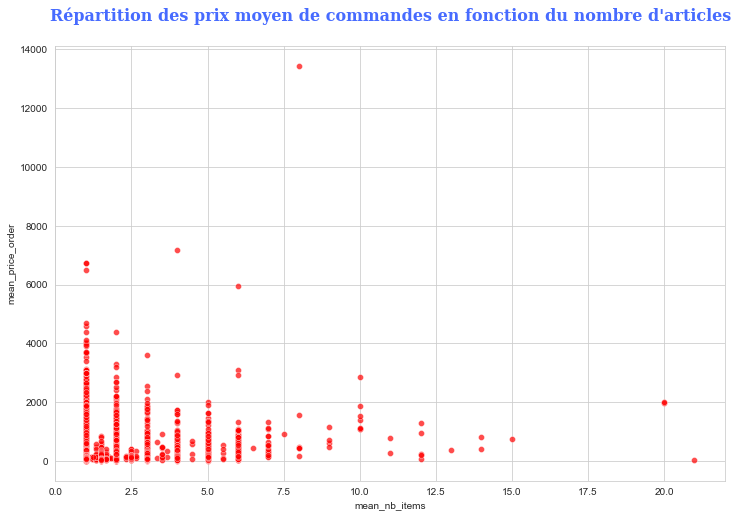

In [74]:
# Dispersion des montants moyennes des commandes :
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(data=data_final, y="mean_price_order", x="mean_nb_items",
                color="red", alpha=0.7)
plt.title(f"Répartition des prix moyen de commandes en fonction du nombre d'articles\n",
          fontdict=font_title, fontsize=16)
plt.show()

Remarque  : 

- Des plusieurs commandes vingtaines ont été achetés pour une somme proche de zéro . 

In [75]:
data_final[data_final["mean_nb_items"] > 20]

customer_unique_id  nb_orders  total_spend  \
25309  4546caea018ad8c692964e3382debd19          1       196.17   

       mean_payment_sequential  mean_payment_installments  mean_review_score  \
25309                      1.0                        2.0                1.0   

       mean_delivery_days  favorite_sale_month  books_cds_media  \
25309                15.0                    7              0.0   

       fashion_clothing_accessories  ...  technology  toys_baby  total_items  \
25309                           0.0  ...         0.0        0.0         21.0   

       mean_nb_items   order_mean_delay  freight_ratio  mean_price_order  \
25309           21.0  409 days 00:00:00           0.84              31.8   

       customer_zip_code_prefix  customer_city  customer_state  
25309                      5882      sao paulo              SP  

[1 rows x 26 columns]

Localisation des clients :

In [76]:
data_final["customer_state"].unique()

array(['SP', 'SC', 'PA', 'PR', 'RJ', 'MA', 'ES', 'RS', 'MG', 'GO', 'DF',
       'BA', 'MT', 'SE', 'TO', 'PE', 'CE', 'AL', 'AC', 'PI', 'PB', 'RN',
       'AM', 'MS', 'AP', 'RO', 'RR'], dtype=object)

In [77]:
import plotly.graph_objects as go
#---------------------------------
#Les 20 villes ayant le plus de vendeurs

ville_populaire_vendeurs = pd.DataFrame(
    df_sellers['seller_city'].value_counts())
fig = go.Figure(go.Bar(y=ville_populaire_vendeurs.head(20).index,
                       x=ville_populaire_vendeurs['seller_city'].head(20),
                       orientation='h', marker=dict(color="Green")))

fig.update_layout(title={'text': 'Top des villes ayant le plus de \
vendeurs',
                         'y': 0.9,
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  xaxis=dict(title='Nombre de vendeurs',
                             linecolor="#CCC",
                             showgrid=True
                             ),
                  yaxis=dict(
    title='Ville',
    linecolor="#CCC",
    showgrid=True
),
    plot_bgcolor="#FFF",)
fig.show()

Remarque : 

- Sao Paulo reste la ville est avec le plus de contributeur pour notre site. 

Les codes des états ne sont pas très parlants ici !

In [78]:
# Nous utiliserons Wikipedia pour modifier les codes états par leur nom :

wiki_url = pd.read_html('https://en.wikipedia.org/wiki/Federative_units_of_Brazil')
states_table = pd.read_html('https://en.wikipedia.org/wiki/Federative_units_of_Brazil')[3].set_index("Code")
states_table.head(3)

Flag and name     Capital Largest city  Area(km2)[20]  \
Code                                                         
AC            Acre  Rio Branco   Rio Branco         164123   
AL         Alagoas      Maceió       Maceió          27779   
AP           Amapá      Macapá       Macapá         142829   

      Population(2022)[21]  Density (perkm2, 2022)  \
Code                                                 
AC                  892000                    6.34   
AL                 3345000                  125.52   
AP                  845000                    2.63   

      GDP (R$millions, 2022)[22]  HDI(2022)[23]  
Code                                             
AC                         21000          0.719  
AL                         73000          0.683  
AP                          9000          0.740

In [79]:
data_final = pd.merge(data_final.reset_index(), states_table[["Flag and name"]],
                how="left",
                left_on="customer_state",
                right_on="Code")
data_final.drop("customer_state", axis=1, inplace=True)
data_final = data_final.rename(columns={"Flag and name": "customer_state"})

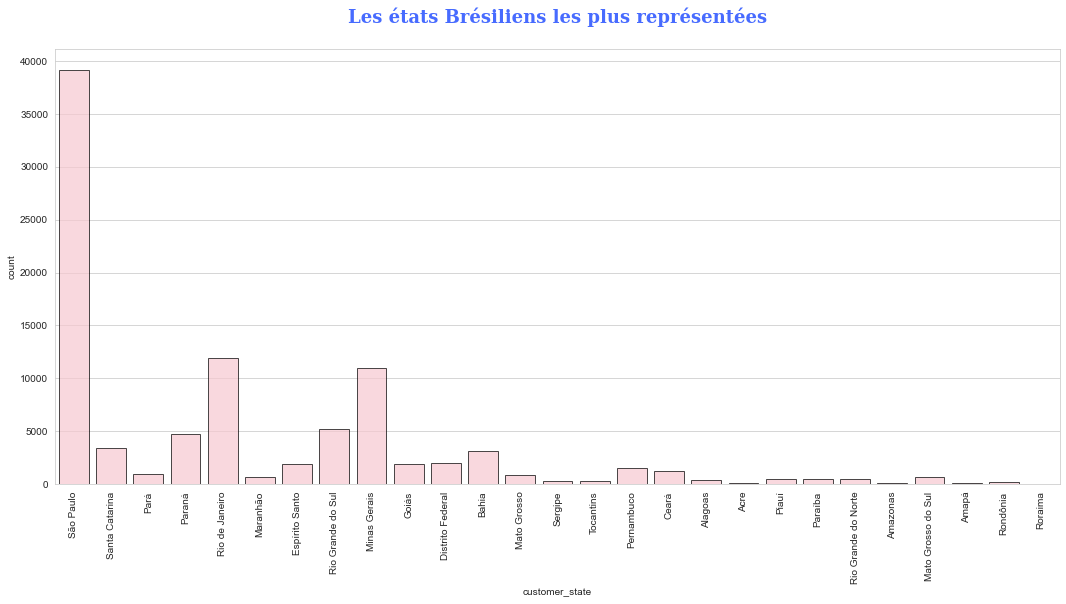

In [80]:
#Les états bréziliens les plus réprésentées :

fig = plt.figure(figsize=(18, 8))
sns.countplot(data=data_final, x="customer_state",
              edgecolor="black",
              color="pink", alpha=0.7)
plt.xticks(range(0, data_final["customer_state"].nunique()),
           data_final["customer_state"].unique(),
           rotation=90)
plt.title(f"Les états Brésiliens les plus représentées\n",
          fontdict=font_title)
plt.show()

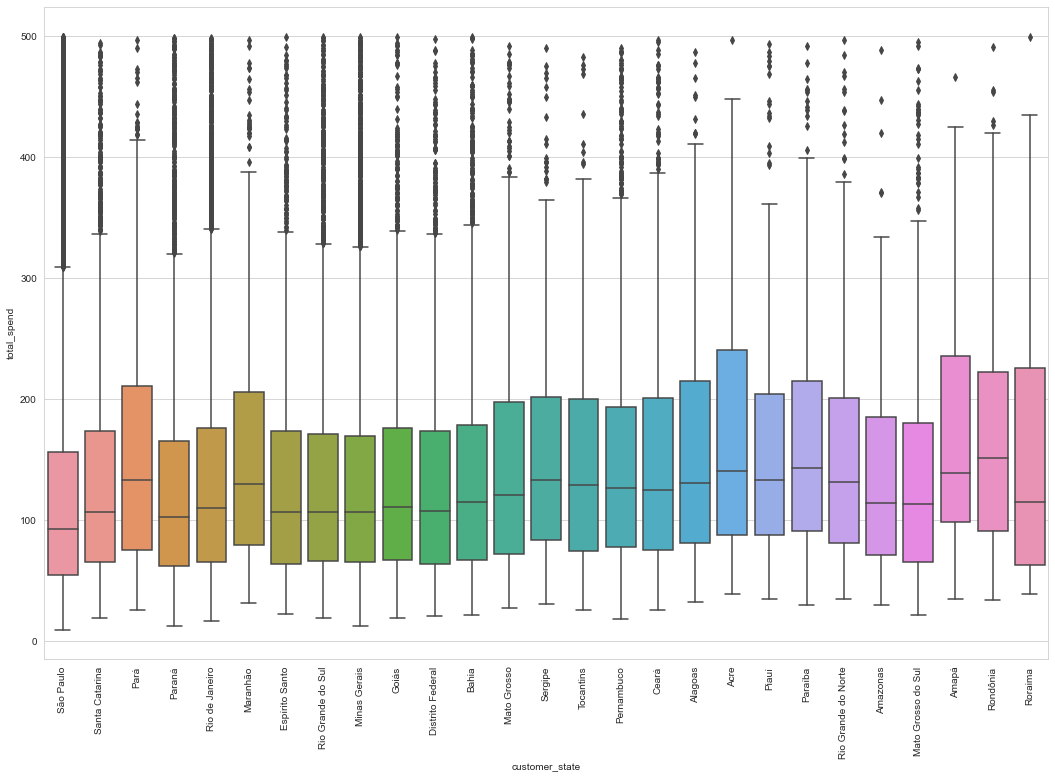

In [81]:
# Total d'envoie par Etats :

fig = plt.figure(figsize=(18,12))
sns.boxplot(x="customer_state", y="total_spend", 
            data=data_final[data_final["total_spend"]<500])
plt.xticks(rotation=90)
plt.show()


Remarque :

- Nous pouvons voir dans ces boxplots que l'état du client a un impact faible sur les variances et médianes des dépenses sur le site.

- Distance de HARVERSINE a utilisé peut-être plus tard pour nos futures modélisations (Calculer la distance Haversine entre l'état du client(moyenne des latitudes et longitudes de l'état)et le siège social d'Olist):


--------------

In [82]:
df_geolocation.head(3)

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP

In [83]:
! pip install geopandas

import plotly.express as px
import geopandas as gpd



In [84]:
!pip install folium
!pip install rioxarray
!pip install earthpy
# Import necessary packages
import os 
import folium
from folium import plugins
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es

# Import data from EarthPy
data = et.data.get_data('colorado-flood')

# Set working directory to earth-analytics
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

In [85]:
# Siège sociale de OLIST :

# Create a map using Stamen Terrain, centered on Boulder, CO
m = folium.Map(location=[-25.43045, -49.29207], 
               tiles = 'Stamen Terrain')

# Add marker for Boulder, CO
folium.Marker(
    location=[-25.43045, -49.29207], # coordinates for the marker (Earth Lab at CU Boulder)
    popup='Siège sociale OList', # pop-up label for the marker
    icon=folium.Icon()
).add_to(m)

# Display m
m

In [86]:
state_location = df_geolocation.groupby("geolocation_state").mean()

state_location = pd.merge(states_table[["Flag and name"]].reset_index(),
                         state_location,
                         right_on="geolocation_state",
                         left_on="Code",
                         how="left")
state_location = state_location[["Flag and name","geolocation_lat","geolocation_lng"]]

#Olist location :

olist_lat = -25.43045
olist_lon = -49.29207

In [87]:
state_location.head(3)

Flag and name  geolocation_lat  geolocation_lng
0          Acre        -9.702555       -68.451852
1       Alagoas        -9.599729       -36.052017
2         Amapá         0.086025       -51.234304

In [88]:
state_location.dtypes

Flag and name       object
geolocation_lat    float64
geolocation_lng    float64
dtype: object

In [89]:
df3 = state_location


------------------------------------

Représentation cartographique des données vue jusqu'à maintenant ainsi qu'un ensemble de représentation graphique :
- Cartographie
- Graphique : paiement | livraison | dépenses | régions

In [90]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
from typing import *
from dataclasses import dataclass
from math import ceil


# Check PEP 8 Compliance
"""
--------------------------------------------
---------- 1. FORMATAGE DES AXES ----------
--------------------------------------------
"""


# Formatage des axes matplotlib
def format_spines(ax, right_border=True):
    """
    Cette fonction définit les bordures à partir d'un axe et personnalise les couleurs

    Imput:
        Axe et drapeau pour décider ou non de tracer la bordure droite
    Return:
        Plot configuration:
    """
    # Setting up colors
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#CCCCCC')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')

# Classe pour tracer des étiquettes de données dans des graphiques à barres
# Référence :https://towardsdatascience.com/annotating-bar-charts-and-other-matplolib-techniques-cecb54315015
#Types d'alias pour réduire la frappe, sans jeu de mots
Patch = matplotlib.patches.Patch
PosVal = Tuple[float, Tuple[float, float]]
Axis = matplotlib.axes.Axes
PosValFunc = Callable[[Patch], PosVal]

@dataclass
class AnnotateBars:
    font_size: int = 10
    color: str = "black"
    n_dec: int = 2
    def horizontal(self, ax: Axis, centered=False):
        def get_vals(p: Patch) -> PosVal:
            value = p.get_width()
            div = 2 if centered else 1
            pos = (
                p.get_x() + p.get_width() / div,
                p.get_y() + p.get_height() / 2,
            )
            return value, pos
        ha = "center" if centered else  "left"
        self._annotate(ax, get_vals, ha=ha, va="center")
    def vertical(self, ax: Axis, centered:bool=False):
        def get_vals(p: Patch) -> PosVal:
            value = p.get_height()
            div = 2 if centered else 1
            pos = (p.get_x() + p.get_width() / 2,
                   p.get_y() + p.get_height() / div
            )
            return value, pos
        va = "center" if centered else "bottom"
        self._annotate(ax, get_vals, ha="center", va=va)
    def _annotate(self, ax, func: PosValFunc, **kwargs):
        cfg = {"color": self.color,
               "fontsize": self.font_size, **kwargs}
        for p in ax.patches:
            value, pos = func(p)
            ax.annotate(f"{value:.{self.n_dec}f}", pos, **cfg)

# Définir des fonctions utiles pour tracer les étiquettes sur le graphique
def make_autopct(values):
    """
    Phase :
        1. définition de fonction pour le formatage des étiquettes

    Arguments:
        valeurs -- valeurs extraites de la fonction value_counts() de la colonne d'analyse [liste]

    Return:
        my_autopct -- chaîne formatée pour le traçage des étiquettes
    """

    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))

        return '{p:.1f}%\n({v:d})'.format(p=pct, v=val)

    return my_autopct

"""
--------------------------------------------
---------- 2. GRAPHIQUES -----------
--------------------------------------------
"""


# Fonction permettant de tracer un graphique en anneau par rapport à une variable de jeu de données spécifique
def donut_plot(df, col, ax, label_names=None, text='', colors=['crimson', 'navy'], circle_radius=0.8,
            title=f'Gráfico de Rosca', flag_ruido=0):
    """
    Phase :
        1. Définition de fonctions utiles pour afficher les étiquettes en valeur absolue et en pourcentage
        2. création de la figure et cercle central de rayon prédéfini
        3. tracer le camembert et ajouter le cercle central
        4. configuration finale de l'intrigue

    Arguments:
        df -- DataFrame à analyser [pandas.DataFrame]
        col -- Colonne DataFrame à analyser [chaîne]
        label_names -- noms personnalisés à tracer sous forme d'étiquettes [liste]
        text -- centrer le texte sur la position [string / default: '']
        couleurs -- couleurs des entrées [list / default: ['crimson', 'navy']]
        figsize -- dimensions du tracé [tuple / défaut : (8, 8)]
        circle_radius -- rayon du cercle central [float/default: 0.8]

    Return:
        None
    """

    # Retour des valeurs et définition du chiffre
    values = df[col].value_counts().values
    if label_names is None:
        label_names = df[col].value_counts().index

    # Vérification du paramètre de suppression de certaines catégories d'analyse
    if flag_ruido > 0:
        values = values[:-flag_ruido]
        label_names = label_names[:-flag_ruido]

    # tracer un graphique en anneau
    center_circle = plt.Circle((0, 0), circle_radius, color='white')
    ax.pie(values, labels=label_names, colors=colors, autopct=make_autopct(values))
    ax.add_artist(center_circle)

    # Configuration des arguments de texte de base(centrale)
    kwargs = dict(size=20, fontweight='bold', va='center')
    ax.text(0, 0, text, ha='center', **kwargs)
    ax.set_title(title, size=14, color='dimgrey')


# Fonction d'analyse de la matrice de corrélation
def target_correlation_matrix(data, label_name, ax, n_vars=10, corr='positive', fmt='.2f', cmap='YlGnBu',
                              cbar=True, annot=True, square=True):
    """
    Phase :
        1. construction de corrélation entre variables
        2. filtrage des k variables les plus corrélées
        3. tracer et mettre en place la matrice de corrélation

    Arguments:
        data -- DataFrame à analyser [pandas.DataFrame]
        label_name -- nom de la colonne contenant la variable de réponse [chaîne]
        n_vars -- indicateur des k principales variables à analyser [int]
        corr -- indicateur booléen pour tracer les corrélations ('positif', 'négatif') [chaîne]
        fmt -- format des nombres de corrélation dans le tracé [chaîne]
        cmap -- mappage des couleurs [chaîne]
        figsize -- dimensions du tracé graphique [tuple]
        cbar -- indicateur de barre latérale indicateur de tracé [bool]
        annot -- indicateur pour annoter les nombres de corrélation dans le tableau [bool]
        carré -- indicateur de redimensionnement de matrice quadratique [bool]

    Return:
        None
    """

    # Création d'une matrice de corrélation pour la base de données
    corr_mx = data.corr()

    # Renvoie uniquement les k premières variables avec la corrélation la plus élevée avec la variable de réponse
    if corr == 'positive':
        corr_cols = list(corr_mx.nlargest(n_vars+1, label_name)[label_name].index)
        title = f'Top {n_vars} Features - Correlação Positiva com o Target'
    elif corr == 'negative':
        corr_cols = list(corr_mx.nsmallest(n_vars+1, label_name)[label_name].index)
        corr_cols = [label_name] + corr_cols[:-1]
        title = f'Top {n_vars} Features - Correlação Negativa com o Target'
        cmap = 'magma'

    corr_data = np.corrcoef(data[corr_cols].values.T)

    # Construire un tracé matriciel
    sns.heatmap(corr_data, ax=ax, cbar=cbar, annot=annot, square=square, fmt=fmt, cmap=cmap,
                yticklabels=corr_cols, xticklabels=corr_cols)
    ax.set_title(title, size=14, color='dimgrey', pad=20)

    return


#Distplot pour la comparaison de la densité des fonctionnalités en fonction de la variable cible
def distplot(df, features, fig_cols, hue=False, color=['crimson', 'darkslateblue'], hist=False, figsize=(16, 12)):
    """
    Phase :
        1. création de la figure selon les spécifications des arguments
        2. boucle pour le tracé de la boîte à moustaches de l'axe
        3. mise en forme graphique
        4. validation des axes excédentaires

    Arguments:
        df -- base de données pour tracer [pandas.DataFrame]
        fonctionnalités -- ensemble de colonnes à évaluer [liste]
        fig_cols -- spécifications de la figure matplotlib [int]
        hue -- variable de réponse contenue dans la base [chaîne -- valeur par défaut : False]
        color_list -- couleurs pour chaque classe dans les graphiques [liste - par défaut : ['crimson', 'darkslateblue']]
        hist -- indicateur de tracé de bande d'histogramme [bool - défaut : False]
        figsize -- dimensions du tracé [tuple - défaut : (16, 12)]

    Return:
        None
    """

    # Définition des variables de contrôle
    n_features = len(features)
    fig_cols = fig_cols
    fig_rows = ceil(n_features / fig_cols)
    i, j, color_idx = (0, 0, 0)

    # tracer des graphiques
    fig, axs = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=figsize)

    # Faire défiler chacune des fonctionnalités
    for col in features:
        try:
            ax = axs[i, j]
        except:
            ax = axs[j]
        target_idx = 0

        # Tracer, pour chaque axe, un graphique par classe cible
        if hue != False:
            for classe in df[hue].value_counts().index:
                df_hue = df[df[hue] == classe]
                sns.distplot(df_hue[col], color=color[target_idx], hist=hist, ax=ax, label=classe)
                target_idx += 1
        else:
            sns.distplot(df[col], color=color, hist=hist, ax=ax)

        # index d'incrémentation
        j += 1
        if j == fig_cols:
            j = 0
            i += 1

        # Personnalisation du traçage
        ax.set_title(f'Feature: {col}', color='dimgrey', size=14)
        plt.setp(ax, yticks=[])
        sns.set(style='white')
        sns.despine(left=True)

    # Traiter un cas séparé : chiffre(s) vide(s)
    i, j = (0, 0)
    for n_plots in range(fig_rows * fig_cols):

        # Si l'indice de l'axe est supérieur au nombre d'entités, éliminez les bords
        if n_plots >= n_features:
            try:
                axs[i][j].axis('off')
            except TypeError as e:
                axs[j].axis('off')

        # incrémentation
        j += 1
        if j == fig_cols:
            j = 0
            i += 1

    # finition personnalisation
    plt.tight_layout()
    plt.show()


# Fonction de traçage stripplot
def stripplot(df, features, fig_cols, hue=False, palette='viridis', figsize=(16, 12)):
    """
    Phase :
        1. création de la figure selon les spécifications des arguments
        2. boucle pour le traçage de stripplot d'axe
        3. mise en forme graphique
        4. validation des axes excédentaires

    Arguments:
        df -- base de données pour tracer [pandas.DataFrame]
        fonctionnalités -- ensemble de colonnes à évaluer [liste]
        fig_cols -- spécifications de la figure matplotlib [int]
        hue -- variable de réponse contenue dans la base [chaîne - par défaut : False]
        palette -- palette de couleurs [chaîne / liste - par défaut : 'viridis']
        figsize -- tracer les dimensions de la figure [tuple - par défaut : (16, 12)]

    Return:
        None
    """

    # Définition des variables de contrôle
    n_features = len(features)
    fig_cols = fig_cols
    fig_rows = ceil(n_features / fig_cols)
    i, j, color_idx = (0, 0, 0)

    #tracer des graphiques
    fig, axs = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=figsize)

    # tracer un graphique
    for col in features:
        try:
            ax = axs[i, j]
        except:
            ax = axs[j]

        # Tracer un graphique en attribuant une variable cible (as hue)
        if hue != False:
            sns.stripplot(x=df[hue], y=df[col], ax=ax, palette=palette)
        else:
            sns.stripplot(y=df[col], ax=ax, palette=palette)

        # tableau de mise en forme
        format_spines(ax, right_border=False)
        ax.set_title(f'Feature: {col.upper()}', size=14, color='dimgrey')
        plt.tight_layout()

        # index d'incrémentation
        j += 1
        if j == fig_cols:
            j = 0
            i += 1

    # Traitement d'un cas séparé : chiffre(s) vide(s)
    i, j = (0, 0)
    for n_plots in range(fig_rows * fig_cols):

        # Si l'index de l'axe est supérieur au nombre d'entités, supprimez les bordures
        if n_plots >= n_features:
            try:
                axs[i][j].axis('off')
            except TypeError as e:
                axs[j].axis('off')

        # Incrémentation
        j += 1
        if j == fig_cols:
            j = 0
            i += 1


def boxenplot(df, features, fig_cols, hue=False, palette='viridis', figsize=(16, 12)):
    """
    Phase :
        1. création de la figure selon les spécifications des arguments
        2. boucle pour le tracé de la boîte à moustaches de l'axe
        3. mise en forme graphique
        4. validation des axes excédentaires

    Arguments:
        df -- base de données pour tracer [pandas.DataFrame]
        fonctionnalités -- ensemble de colonnes à évaluer [liste]
        fig_cols -- spécifications de la figure matplotlib [int]
        hue -- variable de réponse contenue dans la base [chaîne - par défaut : False]
        palette -- palette de couleurs [chaîne / liste - par défaut : 'viridis']
        figsize -- tracer les dimensions de la figure [tuple - par défaut : (16, 12)]

    Return:
        None
    """

    # Définition des variables de contrôle
    n_features = len(features)
    fig_rows = ceil(n_features / fig_cols)
    i, j, color_idx = (0, 0, 0)

    # tracer des graphiques
    fig, axs = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=figsize)

    # tracer des graphiques
    for col in features:
        try:
            ax = axs[i, j]
        except:
            ax = axs[j]

        # Tracer un graphique en attribuant une variable cible (as hue)
        if hue != False:
            sns.boxenplot(x=df[hue], y=df[col], ax=ax, palette=palette)
        else:
            sns.boxenplot(y=df[col], ax=ax, palette=palette)

        # tableau de mise en forme
        format_spines(ax, right_border=False)
        ax.set_title(f'Feature: {col.upper()}', size=14, color='dimgrey')
        plt.tight_layout()

        # index d'incrémentation
        j += 1
        if j == fig_cols:
            j = 0
            i += 1

    # Traitement d'un cas séparé : chiffre(s) vide(s)
    i, j = (0, 0)
    for n_plots in range(fig_rows * fig_cols):

        # Si l'index de l'axe est supérieur au nombre d'entités, supprimez les bordures
        if n_plots >= n_features:
            try:
                axs[i][j].axis('off')
            except TypeError as e:
                axs[j].axis('off')

        # Incrémentation
        j += 1
        if j == fig_cols:
            j = 0
            i += 1


# Fonction chargée de tracer la volumétrie d'une variable catégorielle 
def countplot(df, feature, order=True, hue=False, label_names=None, palette='plasma', colors=['darkgray', 'navy'],
              figsize=(12, 5), loc_legend='lower left', width=0.75, sub_width=0.3, sub_size=12):
    """
    Phase :
        1. personnalisation du tracé en fonction de la présence (ou non) du paramètre de teinte
        2. définition des figures et tracé des graphiques appropriés
        3. personnalisation du tracé

    Arguments:
        df -- DataFrame à analyser [pandas.DataFrame]
        fonctionnalité -- colonne à analyser [chaîne]
        order -- drapeau booléen pour indiquer l'ordre des tracés [bool - par défaut : True]
        hue -- paramètre de rupture d'analyse [chaîne - par défaut : False]
        label_names -- description des étiquettes à placer dans la légende [liste - par défaut : Aucune]
        palette -- palette de couleurs à utiliser dans le tracé singulier de la variable [chaîne - par défaut : 'viridis']
        couleurs -- couleurs à utiliser dans le tracé divisé par la teinte [liste - par défaut : ['darkgray', 'navy']]
        figsize -- dimensions du tracé [tuple - défaut : (15, 5)]
        loc_legend -- position de la légende en cas de tracé par teinte [string - default: 'best']
        largeur -- largeur des barres en cas de tracé par teinte [float - défaut : 0.5]
        sub_width -- paramètre d'alignement de l'étiquette en cas de tracé par teinte [float - défaut : 0.3]

    Return:
        None
    """

    # Vérification du tracé par rupture d’une variable de catégorie
    ncount = len(df)
    if hue != False:
        # Correction des dimensions et tracé du graphique + versus variable de catégorie
        figsize = (figsize[0], figsize[1] * 2)
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize)
        if order:
            sns.countplot(x=feature, data=df, palette=palette, ax=axs[0], order=df[feature].value_counts().index)
        else:
            sns.countplot(x=feature, data=df, palette=palette, ax=axs[0])

        # Traçage graphique par analyse Hue (Stacked bar chart)
        feature_rate = pd.crosstab(df[feature], df[hue])
        percent_df = feature_rate.div(feature_rate.sum(1).astype(float), axis=0)
        if order:
            sort_cols = list(df[feature].value_counts().index)
            sorter_index = dict(zip(sort_cols, range(len(sort_cols))))
            percent_df['rank'] = percent_df.index.map(sorter_index)
            percent_df = percent_df.sort_values(by='rank')
            percent_df = percent_df.drop('rank', axis=1)
            percent_df.plot(kind='bar', stacked=True, ax=axs[1], color=colors, width=width)
        else:
            percent_df.plot(kind='bar', stacked=True, ax=axs[1], color=colors, width=width)
        # sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=axs[1], order=df[feature].value_counts().index)

        #  Insertion d’une étiquette de pourcentage pour un graphique unique
        for p in axs[0].patches:
            # Collecte des paramètres et insertion dans le graphique
            x = p.get_bbox().get_points()[:, 0]
            y = p.get_bbox().get_points()[1, 1]
            axs[0].annotate('{:.1f}%'.format(100. * y / ncount), (x.mean(), y), ha='center', va='bottom',
                            size=sub_size)

        # Insertion d’étiquette de pourcentage pour le graphique (hue)
        for p in axs[1].patches:
            # Collecte des paramètres
            height = p.get_height()
            width = p.get_width()
            x = p.get_x()
            y = p.get_y()

            # Mise en forme des paramètres collectés et insertion dans le graphique
            label_text = f'{round(100 * height, 1)}%'
            label_x = x + width - sub_width
            label_y = y + height / 2
            axs[1].text(label_x, label_y, label_text, ha='center', va='center', color='white', fontweight='bold',
                        size=sub_size)

        #  Définissant des titres
        axs[0].set_title(f'Analyse volumétrique de la variable {feature}', size=14, color='dimgrey', pad=20)
        axs[0].set_ylabel('Volumetrie')
        axs[1].set_title(f'Analyse volumétrique de la variable {feature} par {hue}', size=14, color='dimgrey', pad=20)
        axs[1].set_ylabel('Pourcentage')

        # Mise en forme de l’axe de chaque parcelle
        for ax in axs:
            format_spines(ax, right_border=False)

        # Définition de la légende (par hue)
        plt.legend(loc=loc_legend, title=f'{hue}', labels=label_names)

    else:
        # Tracé unique : pas de rupture - variable hue
        fig, ax = plt.subplots(figsize=figsize)
        if order:
            sns.countplot(x=feature, data=df, palette=palette, ax=ax, order=df[feature].value_counts().index)
        else:
            sns.countplot(x=feature, data=df, palette=palette, ax=ax)

            # Formatage des axes
        ax.set_ylabel('Volumetrie')
        format_spines(ax, right_border=False)

        # Insertion d’une étiquette de pourcentage
        for p in ax.patches:
            x = p.get_bbox().get_points()[:, 0]
            y = p.get_bbox().get_points()[1, 1]
            ax.annotate('{:.1f}%'.format(100. * y / ncount), (x.mean(), y), ha='center', va='bottom')

        # En définissant le titre
        ax.set_title(f'Analyse volumétrique de la variable {feature}', size=14, color='dimgrey')

    # Configurations finales
    plt.tight_layout()
    plt.show()

# fonction responsable du tracé volumétrique d’une variable de catégorie unique dans un format mis à jour
def single_countplot(df, ax, x=None, y=None, top=None, order=True, hue=False, palette='plasma',
                     width=0.75, sub_width=0.3, sub_size=12):
    """
       Paramètres
    ----------
    classifiers: ensemble de classificateurs en forme de dictionnaire [dict]
    X: tableau avec les données à utiliser dans la formation [np.array]
    y: tableau avec le vecteur cible du modèle [np.array]

    Return
    -------
    None
    """

    # Vérification du tracé par rupture d’une variable de catégorie
    ncount = len(df)
    if x:
        col = x
    else:
        col = y

    # Vérifier le tracé des meilleures catégories
    if top is not None:
        cat_count = df[col].value_counts()
        top_categories = cat_count[:top].index
        df = df[df[col].isin(top_categories)]

    #  Valider et tracer un graphique
    if hue != False:
        if order:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, order=df[col].value_counts().index, hue=hue)
        else:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, hue=hue)
    else:
        if order:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, order=df[col].value_counts().index)
        else:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax)

    # Formatage des axes
    format_spines(ax, right_border=False)

    # Insertion d’une étiquette de pourcentage
    if x:
        for p in ax.patches:
            x = p.get_bbox().get_points()[:, 0]
            y = p.get_bbox().get_points()[1, 1]
            ax.annotate('{}\n{:.1f}%'.format(int(y), 100. * y / ncount), (x.mean(), y), ha='center', va='bottom')
    else:
        for p in ax.patches:
            x = p.get_bbox().get_points()[1, 0]
            y = p.get_bbox().get_points()[:, 1]
            ax.annotate('{} ({:.1f}%)'.format(int(x), 100. * x / ncount), (x, y.mean()), va='center')


#Fonction de traçage volumétrique des variables de catégorie de l’ensemble de données
def catplot_analysis(df_categorical, fig_cols=3, hue=False, palette='viridis', figsize=(16, 10)):
    """
    Étapes:
        1. retour des variables de catégorie de l’ensemble de données
        2. paramétrage des variables de traçage
        3. application de boucles de répétition pour les tracés / formatage

    Arguments:
        df -- ensemble de données à analyser [pandas.DataFrame]
        fig_cols -- nombre de colonnes de la figure matplotlib [int]

    Return:
        None
    """

    # Retour des paramètres pour l’organisation de la figure
    if hue != False:
        cat_features = list(df_categorical.drop(hue, axis=1).columns)
    else:
        cat_features = list(df_categorical.columns)

    total_cols = len(cat_features)
    fig_cols = fig_cols
    fig_rows = ceil(total_cols / fig_cols)
    ncount = len(cat_features)

    # Retour des paramètres pour l’organisation de la figure
    sns.set(style='white', palette='muted', color_codes=True)
    total_cols = len(cat_features)
    fig_rows = ceil(total_cols / fig_cols)

    #Créer une figure 
    fig, axs = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(figsize))
    i, j = 0, 0

    # Boucle de répétition pour le traçage de catégorie
    for col in cat_features:
        # Indexation des variables et traçage graphique
        try:
            ax = axs[i, j]
        except:
            ax = axs[j]
        if hue != False:
            sns.countplot(y=col, data=df_categorical, palette=palette, ax=ax, hue=hue,
                          order=df_categorical[col].value_counts().index)
        else:
            sns.countplot(y=col, data=df_categorical, palette=palette, ax=ax,
                          order=df_categorical[col].value_counts().index)

        # Personnalisation du graphique
        format_spines(ax, right_border=False)
        AnnotateBars(n_dec=0, color='dimgrey').horizontal(ax)
        ax.set_title(col)

        # Incrémentation des indices d’axe
        j += 1
        if j == fig_cols:
            j = 0
            i += 1

    # En cas : figure(s) vide(s)
    i, j = (0, 0)
    for n_plots in range(fig_rows * fig_cols):

        # Si l’indice de l’axe est supérieur au nombre de caractéristiques, il élimine les bords
        if n_plots >= len(cat_features):
            try:
                axs[i][j].axis('off')
            except TypeError as e:
                axs[j].axis('off')

        # Incrémentation
        j += 1
        if j == fig_cols:
            j = 0
            i += 1

    plt.tight_layout()
    plt.show()


# Fonction de traçage volumétrique des variables de catégorie de l’ensemble de données
def numplot_analysis(df_numerical, fig_cols=3, color_sequence=['darkslateblue', 'mediumseagreen', 'darkslateblue'],
                     hue=False, color_hue=['darkslateblue', 'crimson'], hist=False):
    """
    Étapes:
        1. retour des variables de catégorie de l’ensemble de données
        2. paramétrage des variables de traçage
        3. application de boucles de répétition pour les tracés / formatage

    Arguments:
        df -- ensemble de données à analyser [pandas.DataFrame]
        fig_cols -- nombre de colonnes de la figure matplotlib [int]

    Return:
        None
    """

    # Configuration des paramètres de seaborn
    sns.set(style='white', palette='muted', color_codes=True)

    # Création d’un DataFrame de variables de catégorie
    #num_features = [col for col, dtype in df.dtypes.items() if dtype != 'object']
    #df_numerical = df.loc[:, num_features]

    # Retour des paramètres pour l’organisation de la figure
    if hue != False:
        num_features = list(df_numerical.drop(hue, axis=1).columns)
    else:
        num_features = list(df_numerical.columns)

    total_cols = len(num_features)
    fig_cols = fig_cols
    fig_rows = ceil(total_cols / fig_cols)

    #  Créer une figure
    fig, axs = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(fig_cols * 5, fig_rows * 4.5))
    sns.despine(left=True)
    i, j = 0, 0

    # Boucle de répétition pour le traçage de catégorie
    color_idx = 0
    for col in num_features:
        # Indexation des variables et traçage graphique
        try:
            ax = axs[i, j]
        except:
            ax = axs[j]
        target_idx = 0

        if hue != False:
            for classe in df_numerical[hue].value_counts().index:
                df_hue = df_numerical[df_numerical[hue] == classe]
                sns.distplot(df_hue[col], color=color_hue[target_idx], hist=hist, ax=ax, label=classe)
                target_idx += 1
                ax.set_title(col)
        else:
            sns.distplot(df_numerical[col], color=color_sequence[color_idx], hist=hist, ax=ax)
            ax.set_title(col, color=color_sequence[color_idx])

        # Personnalisation du graphique
        format_spines(ax, right_border=False)

        # Incrémentation des indices d’axe
        color_idx += 1
        j += 1
        if j == fig_cols:
            j = 0
            i += 1
            color_idx = 0

    # En cas  : figure(s) vide(s
    i, j = (0, 0)
    for n_plots in range(fig_rows * fig_cols):

        #  Si l’indice de l’axe est supérieur au nombre de caractéristiques, il élimine les bords
        if n_plots >= len(num_features):
            try:
                axs[i][j].axis('off')
            except TypeError as e:
                axs[j].axis('off')

        # Incrémentation
        j += 1
        if j == fig_cols:
            j = 0
            i += 1

    plt.setp(axs, yticks=[])
    plt.tight_layout()
    plt.show()


# Fonction de traçage de représentativité de chaque catégorie(par  hue spécifique)
def catplot_percentage_analysis(df_categorical, hue, fig_cols=2, palette='viridis', figsize=(16, 10)):
    """
     Étapes:
        1. retour des variables de catégorie de l’ensemble de données
        2. paramétrage des variables de traçage
        3. application de boucles de répétition pour les tracés / formatage

    Arguments:
        df -- ensemble de données à analyser [pandas.DataFrame]
        fig_cols -- nombre de colonnes de la figure matplotlib [int]

    Return:
        None
    """
 
    # Retour des paramètres pour l’organisation de la figure
    sns.set(style='white', palette='muted', color_codes=True)
    cat_features = list(df_categorical.drop(hue, axis=1).columns)
    total_cols = len(cat_features)
    fig_rows = ceil(total_cols / fig_cols)

    # Créer une figure 
    fig, axs = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(figsize))
    i, j = 0, 0

    # Boucle de répétition pour le traçage de catégorie
    for col in cat_features:
        # Indexation des variables et traçage graphique
        try:
            ax = axs[i, j]
        except:
            ax = axs[j]

        # Application de crosstab pour l’analyse de la représentativité de la catégorie
        col_to_hue = pd.crosstab(df_categorical[col], df_categorical[hue])
        col_to_hue.div(col_to_hue.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True, ax=ax,
                                                                     colors=palette)

        # Personnalisation du graphique
        format_spines(ax, right_border=False)
        ax.set_title(col)
        ax.set_ylabel('')

        # Incrémentation des indices d’axe
        j += 1
        if j == fig_cols:
            j = 0
            i += 1

    # En cas  : figure(s) vide(s)
    i, j = (0, 0)
    for n_plots in range(fig_rows * fig_cols):

        # Si l’indice de l’axe est supérieur au nombre de caractéristiques, il élimine les bords
        if n_plots >= len(cat_features):
            try:
                axs[i][j].axis('off')
            except TypeError as e:
                axs[j].axis('off')

        # Incrémentation
        j += 1
        if j == fig_cols:
            j = 0
            i += 1

    plt.tight_layout()
    plt.show()


def mean_sum_analysis(df, group_col, value_col, orient='vertical', palette='plasma', figsize=(15, 6)):
    """
    Paramètres
    ----------
    classifiers: ensemble de classificateurs en forme de dictionnaire [dict]
    y: tableau avec le vecteur cible du modèle [np.array]
    X: tableau avec les données à utiliser dans la formation [np.array]

    Return
    -------
    None
    """

    # Grouping data
    df_mean = df.groupby(group_col, as_index=False).mean()
    df_sum = df.groupby(group_col, as_index=False).sum()

    # Sorting grouped dataframes
    df_mean.sort_values(by=value_col, ascending=False, inplace=True)
    sorter = list(df_mean[group_col].values)
    sorter_idx = dict(zip(sorter, range(len(sorter))))
    df_sum['mean_rank'] = df_mean[group_col].map(sorter_idx)
    df_sum.sort_values(by='mean_rank', inplace=True)
    df_sum.drop('mean_rank', axis=1, inplace=True)

    # Plotting data
    fig, axs = plt.subplots(ncols=2, figsize=figsize)
    if orient == 'vertical':
        sns.barplot(x=value_col, y=group_col, data=df_mean, ax=axs[0], palette=palette)
        sns.barplot(x=value_col, y=group_col, data=df_sum, ax=axs[1], palette=palette)
        AnnotateBars(n_dec=0, font_size=12, color='black').horizontal(axs[0])
        AnnotateBars(n_dec=0, font_size=12, color='black').horizontal(axs[1])
    elif orient == 'horizontal':
        sns.barplot(x=group_col, y=value_col, data=df_mean, ax=axs[0], palette=palette)
        sns.barplot(x=group_col, y=value_col, data=df_sum, ax=axs[1], palette=palette)
        AnnotateBars(n_dec=0, font_size=12, color='black').vertical(axs[0])
        AnnotateBars(n_dec=0, font_size=12, color='black').vertical(axs[1])

    # Customizing plot
    for ax in axs:
        format_spines(ax, right_border=False)
        ax.set_ylabel('')
    axs[0].set_title(f'Mean of {value_col} by {group_col}', size=14, color='dimgrey')
    axs[1].set_title(f'Sum of {value_col} by {group_col}', size=14, color='dimgrey')

    plt.tight_layout()
    plt.show()


def answear_plot(grouped_data, grouped_col, list_cols, axs, top=5, bottom_filter=True, palette='plasma'):
    """
    Paramètres
    ----------
    grouped_data: pandas DataFrame avec les données déjà regroupées pour analyse [pd.DataFrame]
    grouped_col: référence de la colonne pivot utilisée dans le groupement [string]
    list_cols: liste des colonnes à utiliser dans l’analyse [list]
    axs: axes à utiliser pour le traçage [matplotlib.axis]
    top: nombre d’entrées dans les analyses tête et queue [int, default: 5]
    bottom_filter: drapeau pour le filtrage des éléments avec au moins 1 occurrence dans le bot [bool, default : True]
    palette: palette de couleurs utilisée dans le tracé [string, default: 'plasma']

    Return
    -------
    None
    """

    # Extracting plot dims and looking at number of cols
    nrows = axs.shape[0]
    ncols = axs.shape[1]
    if len(list_cols) != ncols:
        print(f'Number of cols passed in list_cols arg is different for figure cols axis. Please check it.')
        return None

    # Iterating over columns in the list and creating charts
    i, j = 0, 0
    for col in list_cols:
        ax0 = axs[-3, j]
        ax1 = axs[-2, j]
        ax2 = axs[-1, j]
        sorted_data = grouped_data.sort_values(by=col, ascending=False)

        # First Line: Top entries
        sns.barplot(x=col, y=grouped_col, data=sorted_data.head(top), ax=ax1, palette=palette)
        ax1.set_title(f'Top {top} {grouped_col.capitalize()} with Highest \n{col.capitalize()}')

        # Second Line: Bottom entries
        if bottom_filter:
            sns.barplot(x=col, y=grouped_col, data=sorted_data[sorted_data[col] > 0].tail(top), ax=ax2,
                        palette=palette+'_r')
        else:
            sns.barplot(x=col, y=grouped_col, data=sorted_data.tail(top), ax=ax2, palette=palette+'_r')
        ax2.set_title(f'Top {top} {grouped_col.capitalize()} with Lowest \n{col.capitalize()}')

        # Customizing charts
        for ax in ax1, ax2:
            ax.set_xlim(0, grouped_data[col].max())
            ax.set_ylabel('')
            format_spines(ax, right_border=False)

        # Annotations
        mean_ind = grouped_data[col].mean()
        ax0.text(0.50, 0.30, round(mean_ind, 2), fontsize=45, ha='center')
        ax0.text(0.50, 0.12, f'is the average of {col}', fontsize=12, ha='center')
        ax0.text(0.50, 0.00, f'by {grouped_col}', fontsize=12, ha='center')
        ax0.axis('off')

        j += 1

"""
--------------------------------------------
-------- 3. ANALYSE DES DATAFRAMES---------
--------------------------------------------
"""


def data_overview(df, corr=False, label_name=None, sort_by='qtd_null', thresh_percent_null=0, thresh_corr_label=0):
    """
    Étapes:
        1. enquête d’attributs avec des données nulles dans l’ensemble
        2. analyse du type primitif de chaque attribut
        3. analyse de la quantité d’entrées en cas d’attributs catégoriques
        4. extraction de la corrélation pearson avec la cible pour chaque attribut
        5. application de règles définies dans les arguments
        6. retour de la vue d’ensemble créée

    Arguments:
        df -- DataFrame à analyser [pandas.DataFrame]
        label_name -- nom de la variable target [string]
        sort_by -- colonne de tri du dataset overview [string - default: 'qtd_null']
        thresh_percent_null -- filtre de données nulles [int - default: 0]
        threh_corr_label -- filtre de corrélation avec la cible [int - default: 0]

    Retour
        df_overview -- dataet consolidé contenant l’analyse des colonnes [pandas.DataFrame]
    """

    # Création de DataFrame avec des informations de données nulles
    df_null = pd.DataFrame(df.isnull().sum()).reset_index()
    df_null.columns = ['feature', 'qtd_null']
    df_null['percent_null'] = df_null['qtd_null'] / len(df)

    # Retourner le type primitif et la quantité d’entrées pour les catégories
    df_null['dtype'] = df_null['feature'].apply(lambda x: df[x].dtype)
    df_null['qtd_cat'] = [len(df[col].value_counts()) if df[col].dtype == 'object' else 0 for col in
                          df_null['feature'].values]

    if corr:
        # Extraction des informations de corrélation avec la cible(target)
        label_corr = pd.DataFrame(df.corr()[label_name])
        label_corr = label_corr.reset_index()
        label_corr.columns = ['feature', 'target_pearson_corr']

        # Unissant des informations
        df_null_overview = df_null.merge(label_corr, how='left', on='feature')
        df_null_overview.query('target_pearson_corr > @thresh_corr_label')
    else:
        df_null_overview = df_null

    # Filtrage des données nulles selon des seuils
    df_null_overview.query('percent_null > @thresh_percent_null')

    # DataFrame
    df_null_overview = df_null_overview.sort_values(by=sort_by, ascending=False)
    df_null_overview = df_null_overview.reset_index(drop=True)

    return df_null_overview

In [91]:
def calc_working_days(date_series1, date_series2, convert=True):
    """
Cette fonction reçoit deux séries de dates sous forme d’args et calcule les jours ouvrables entre chacune de ses lignes.

    Paramètres
    ----------
param date_series1: première série de dates à utiliser pour le calcul des jours ouvrables [type: pd.Series]
param date_series2: deuxième série de dates pour soustraire la première [type: pd.Series]
param convert: flag qui guide les conversions de séries dans les objets datetime [type: bool, default: True]

    Retour
    ------
return: wd_list: liste avec calcul des jours ouvrables entre deux séries de dates

    Application
    -----------
    # Calcul des jours ouvrables entre deux séries de dates
    working_days = calc_working_days(df['purchase_date'], df['delivered_date'], convert=True)
    """

    # Auxiliar function for threating exceptions during the np.busday_count() function
    def handle_working_day_calc(d1, d2):
        try:
            date_diff = np.busday_count(d1, d2)
            return date_diff
        except:
            return np.NaN

    # Applying conversion on series in datetime data
    if convert:
        date_series1 = pd.to_datetime(date_series1).values.astype('datetime64[D]')
        date_series2 = pd.to_datetime(date_series2).values.astype('datetime64[D]')

    # Building a list with working days calculations between the two dates
    wd_list = [handle_working_day_calc(d1, d2) for d1, d2 in zip(date_series1, date_series2)]

    return wd_list

In [92]:
df_overview = pd.DataFrame({})
name_col = []
for name, df in zip(names, datasets):
    name_col += [name] * df.shape[1]
    df_overview = df_overview.append(data_overview(df))
    df_overview['dataset_name'] = name_col

df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]
df_overview.head(3)

dataset_name                   feature  qtd_null  percent_null   dtype  \
0  olist_customer               customer_id         0           0.0  object   
1  olist_customer        customer_unique_id         0           0.0  object   
2  olist_customer  customer_zip_code_prefix         0           0.0   int64   

   qtd_cat  
0    99441  
1    96096  
2        0

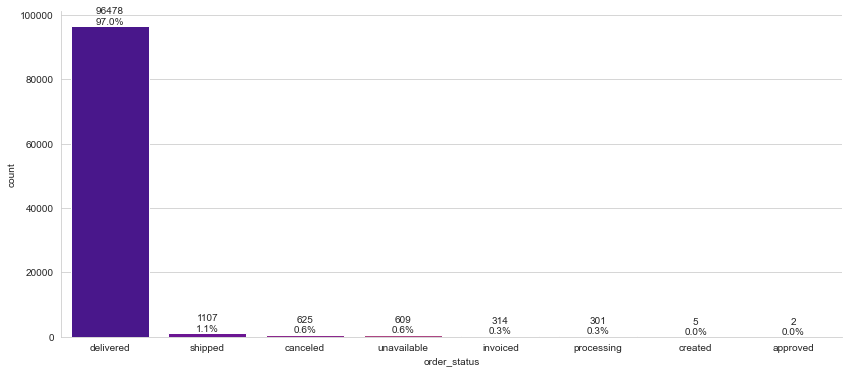

In [93]:
df_orders = olist_orders.merge(olist_customer, how='left', on='customer_id')
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df_orders, x='order_status', ax=ax)
plt.show()

Remarque:

 - le plus grand nombre de commandes provenait des commandes délivrées. Seulement 3 % de toutes les commandes étaient issues des autres statuts !

In [94]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix  ... order_purchase_year order_purchase_month  \
0                      3149  ...                2017                   10   
1                     47813  ...                2018                    7   
2                     75265  ...                2018                    8   
3                     59296  ...                2017                   11   
4                      9195  ...                2018                    2   

   order_purchase_month_name  order_purchase_year_month order_purchase_date  \
0                        Oct                     201710            20171002   
1                        Jul                     201807            20180724   
2                        Aug                     201808            20180808   
3                        Nov                     201711            20171118   
4                        Feb                     201802            20180213   

  order_purchase_day order_purchase_dayofweek  order_purchase_dayofweek_name  \
0                  2                        0                            Mon   
1                 24                        1                            Tue   
2                  8                        2                            Wed   
3                 18                        5                            Sat   
4                 13                        1                            Tue   

   order_purchase_hour order_purchase_time_day  
0                   10                 Morning  
1                   20                   Night  
2                    8                 Morning  
3                   19                   Night  
4                   21                   Night  

[5 rows x 22 columns]

In [95]:
from matplotlib.gridspec import GridSpec
import json
import requests

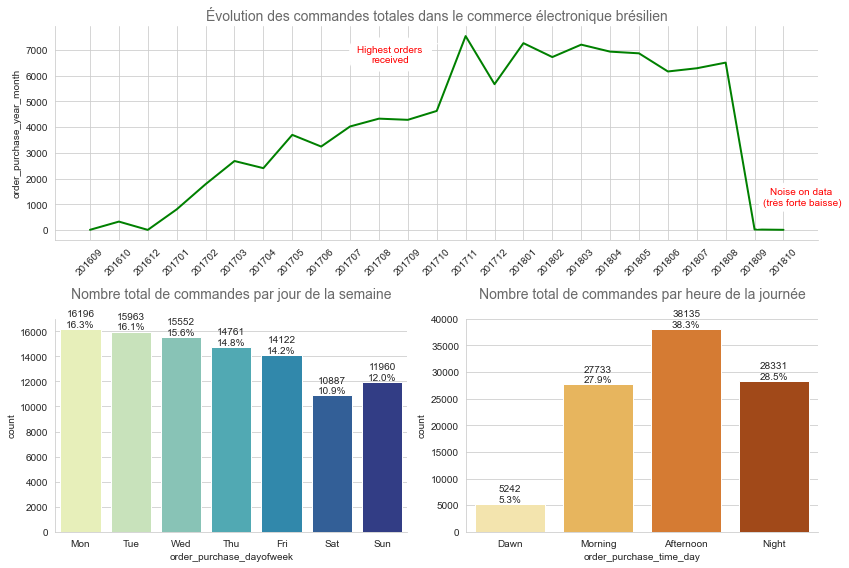

In [96]:
fig = plt.figure(constrained_layout=True, figsize=(12, 8))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='green', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='red', ha='center')
ax1.annotate(f'Noise on data \n(très forte baisse)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='red', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Évolution des commandes totales dans le commerce électronique brésilien', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
single_countplot(df_orders, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Nombre total de commandes par jour de la semaine', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(df_orders, x='order_purchase_time_day', ax=ax3, order=False, palette='YlOrBr')
ax3.set_title('Nombre total de commandes par heure de la journée', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

Remarque :

- Le commerce électronique au Brésil a vraiment une tendance croissante au fil du temps. Nous pouvons voir <strong>une certaine saisonnalité </strong>avec des pics à des mois spécifiques, mais en général, nous pouvons voir - clairement que les clients sont plus enclins à acheter des choses en ligne qu'auparavant.

- <strong>Le lundi est le jour préféré des clients brésiliens et ils ont tendance à acheter davantage l'après-midi.</strong>

Note : nous avons une forte baisse entre août 2018 et septembre 2018 et peut-être que l'origine de cela est liée au bruit sur les données.
    Pour une comparaison plus approfondie entre 2017 et 2018, considérons simplement les commandes entre janvier et août des deux années

E-commerce(O-list): comparaison entre 2017 et 2018

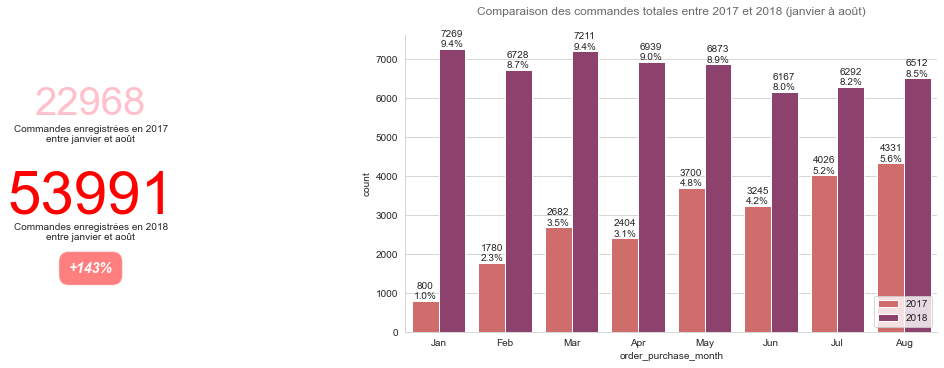

In [97]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Grown on e-commerce orders between 2017 and 2018
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='pink', ha='center')
ax1.text(0.00, 0.64, 'Commandes enregistrées en 2017\nentre janvier et août', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='red', ha='center')
ax1.text(0.00, 0.31, 'Commandes enregistrées en 2018\nentre janvier et août', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='red', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
single_countplot(df_orders_compare, x='order_purchase_month', hue='order_purchase_year', ax=ax2, order=False,
                 palette='flare')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Comparaison des commandes totales entre 2017 et 2018 (janvier à août)', size=12, color='dimgrey', pad=20)
plt.legend(loc='lower right')
plt.show()

In [98]:
# Merging orders and order_items
df_orders_items = df_orders.merge(olist_order_items, how='left', on='order_id')

# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Threting geolocations outside brazilian map

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_prep = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations
df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
df_orders_items.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix  ... freight_value  id  sigla  \
0                      3149  ...          8.72  35     SP   
1                     47813  ...         22.76  29     BA   
2                     75265  ...         19.22  52     GO   
3                     59296  ...         27.20  24     RN   
4                      9195  ...          8.72  35     SP   

                  nome   nome_regiao geolocation_zip_code_prefix  \
0            São Paulo       Sudeste                      3149.0   
1                Bahia      Nordeste                     47813.0   
2                Goiás  Centro-Oeste                     75265.0   
3  Rio Grande do Norte      Nordeste                     59296.0   
4            São Paulo       Sudeste                      9195.0   

  geolocation_lat  geolocation_lng         geolocation_city geolocation_state  
0      -23.583885       -46.587473                sao paulo                SP  
1      -12.945892       -45.016313                barreiras                BA  
2      -16.752735       -48.522139               vianopolis                GO  
3       -5.778488       -35.281450  sao goncalo do amarante                RN  
4      -23.760018       -46.524784              santo andre                SP  

[5 rows x 37 columns]

In [99]:
# Filtering data between 201701 and 201808
df_orders_filt = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]

# Grouping data by region
df_regions_group = df_orders_filt.groupby(by=['order_purchase_year_month', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by='order_purchase_year_month')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)

# Grouping data by city (top 10)
df_cities_group = df_orders_filt.groupby(by='geolocation_city', 
                                       as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
df_cities_group = df_cities_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
df_cities_group = df_cities_group.iloc[:10, :]

Un aperçu de la commande du client par région, état et par ville !

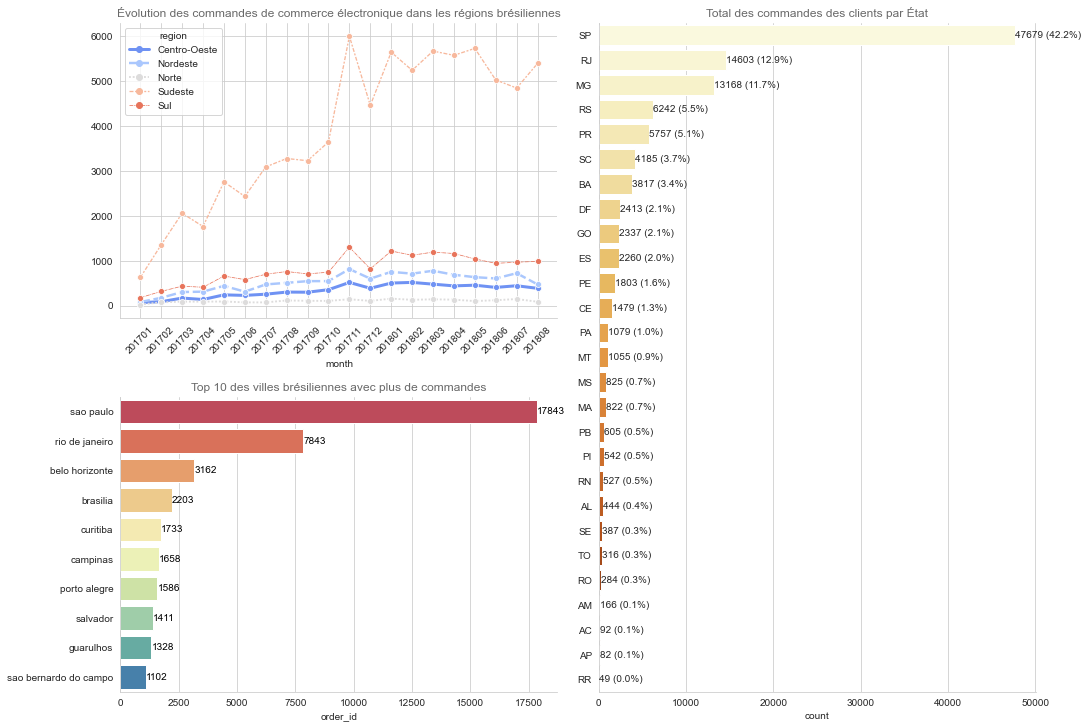

In [100]:
# Creating and preparing figure and axis
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

# Count of orders by region
sns.lineplot(x='month', y='order_count', ax=ax1, data=df_regions_group, hue='region', 
             size='region', style='region', palette='coolwarm', markers=['o'] * 5)
format_spines(ax1, right_border=False)
ax1.set_title('Évolution des commandes de commerce électronique dans les régions brésiliennes', size=12, color='dimgrey')
ax1.set_ylabel('')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Top cities with more customers orders in Brazil
sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, ax=ax2, palette='Spectral')
AnnotateBars(n_dec=0, font_size=10, color='black').horizontal(ax2)
format_spines(ax2, right_border=False)
ax2.set_title('Top 10 des villes brésiliennes avec plus de commandes', size=12, color='dimgrey')
ax2.set_ylabel('')

# Total orders by state
single_countplot(y='customer_state', ax=ax3, df=df_orders_filt, palette='YlOrBr')
ax3.set_title('Total des commandes des clients par État', size=12, color='dimgrey')
ax3.set_ylabel('')

plt.show()

Comment sont répartis les clients au Brésil ? (un échantillon de 30 000 commandes sur l'année 2018 )

In [101]:
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

In [102]:
# Zipping locations
lats = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1


Par la carte que nous avons montrée ci-dessus, nous avons déjà l'idée que le sud-est du Brésil a le plus grand nombre de commandes passées via le commerce électronique.
Nous pouvons avoir un meilleur aperçu sur carte de température !

N.B: le siège social d'O-list se situe aussi cette région du Brésil !

In [103]:
# Grouping geolocation data for plotting a heatmap
heat_data = df_orders_filt.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

# Creating a mapa using folium
map1 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMap
HeatMap(
    name='Mapa de Calor',
    data=heat_data,
    radius=10,
    max_zoom=13
).add_to(map1)

map1

Voir l'évolution des commandes e-commerce dans le temps. Nous montrerons l'évolution des commandes de janvier 2018 à juillet 2018 .


In [104]:
epoch_list = []
heatmap_evl_data = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201801)]
heatmap_evl_data = heatmap_evl_data[(heatmap_evl_data['order_purchase_year_month'].astype(int) <= 201807)]
time_index = heatmap_evl_data['order_purchase_year_month'].sort_values().unique()
for epoch in time_index:
    data_temp = heatmap_evl_data.query('order_purchase_year_month == @epoch')
    data_temp = data_temp.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count()
    data_temp = data_temp.sort_values(by='order_id', ascending=False).iloc[:, :3]
    epoch_list.append(data_temp.values.tolist())
    
# Creating a mapa using folium
map2 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMapWithTime
HeatMapWithTime(
    name='Evolution of Orders in a Geolocation Perspective',
    data=epoch_list,
    radius=10,
    index=list(time_index)
).add_to(map2)

map2

Maintenant, nous allons analyser l'argent déplacé par le commerce électronique en examinant les prix des commandes, les frets et autres.

- Pour répondre à cette question, regroupons d'abord nos données de manière à voir l'évolution globale.

In [105]:
# Grouping data
df_month_aggreg = df_orders_filt.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False)
df_month_aggreg = df_month_aggreg.agg({
    'order_id': 'count',
    'price': 'sum',
    'freight_value': 'sum'
})

# Adding new columns for analysis
df_month_aggreg['price_per_order'] = df_month_aggreg['price'] / df_month_aggreg['order_id']
df_month_aggreg['freight_per_order'] = df_month_aggreg['freight_value'] / df_month_aggreg['order_id']
df_month_aggreg.head()

order_purchase_year order_purchase_year_month  order_id      price  \
0                 2017                    201701       966  120312.87   
1                 2017                    201702      1998  247303.02   
2                 2017                    201703      3041  374344.30   
3                 2017                    201704      2697  359927.23   
4                 2017                    201705      4176  506071.14   

   freight_value  price_per_order  freight_per_order  
0       16875.62       124.547484          17.469586  
1       38977.60       123.775285          19.508308  
2       57704.29       123.099079          18.975432  
3       52495.01       133.454664          19.464223  
4       80119.81       121.185618          19.185778

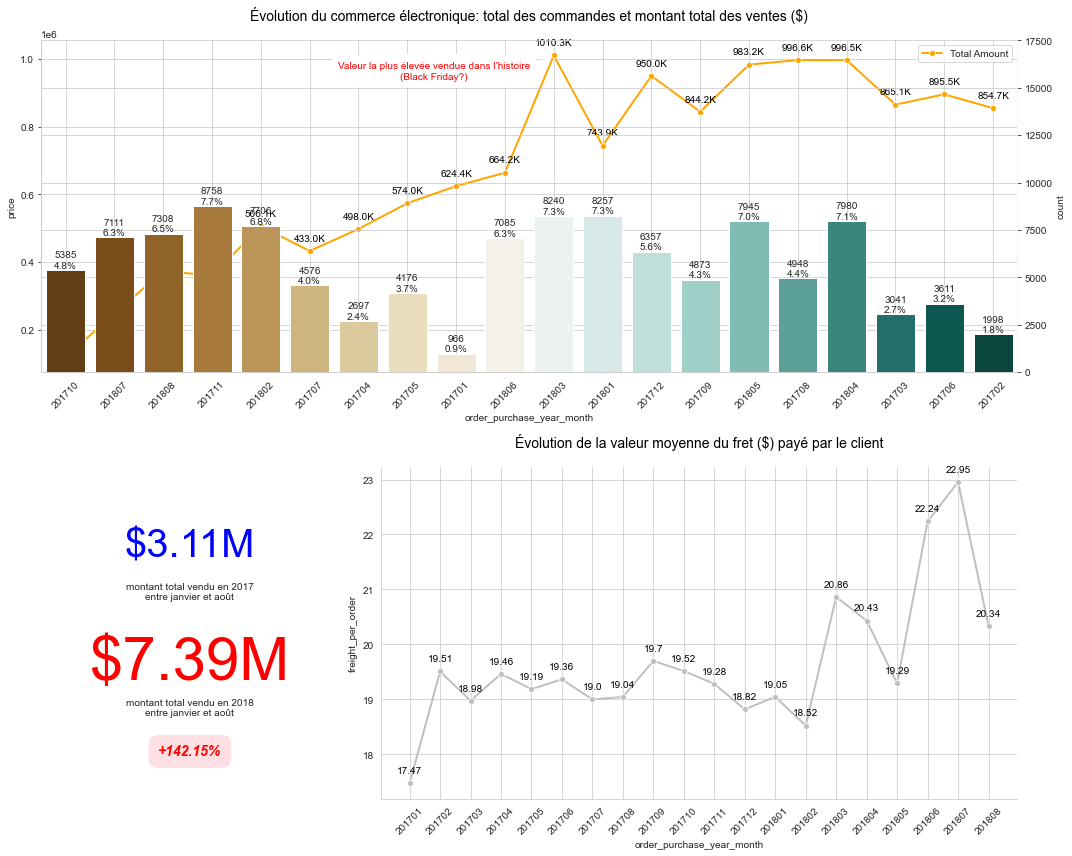

In [106]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])

# Plot 1 - Evolution of total orders and total sales on e-commerce
sns.lineplot(x='order_purchase_year_month', y='price', ax=ax1, data=df_month_aggreg, linewidth=2, 
             color='orange', marker='o', label='Total Amount')
ax1_twx = ax1.twinx()
single_countplot(df_orders_filt, x='order_purchase_year_month', ax=ax1_twx, order=False, palette='BrBG')
ax1_twx.set_yticks(np.arange(0, 20000, 2500))

# Customizing the first plot
format_spines(ax1)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.price.items():
    ax1.annotate(str(round(y/1000, 1))+'K', xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='black')
ax1.annotate(f'Valeur la plus élevée vendue dans l’histoire\n(Black Friday?)', (10, 1000000), xytext=(-120, -20), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='red', ha='center')
ax1.set_title('Évolution du commerce électronique: total des commandes et montant total des ventes ($)', size=14, color='black', pad=20)

# Plot 2 - Big Numbers of Sales Evolution
month_comparison = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708',
                    '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808']
df_sales_compare = df_month_aggreg.query('order_purchase_year_month in (@month_comparison)')
sold_2017 = df_sales_compare.query('order_purchase_year == 2017')['price'].sum()
sold_2018 = df_sales_compare.query('order_purchase_year == 2018')['price'].sum()
growth = 1 + (sold_2017 / sold_2018)
ax2.text(0.50, 0.73, '$' + str(round(sold_2017/1000000, 2)) + 'M', fontsize=40, color='Blue', ha='center')
ax2.text(0.50, 0.60, 'montant total vendu en 2017\nentre janvier et août', fontsize=10, ha='center')
ax2.text(0.50, 0.36, '$' + str(round(sold_2018/1000000, 2)) + 'M', fontsize=60, color='red', ha='center')
ax2.text(0.50, 0.25, 'montant total vendu en 2018\nentre janvier et août', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.50, 0.13, f'{signal}{str(round(100 * growth, 2))}%', fontsize=14, ha='center', color='red', style='italic', weight='bold',
         bbox=dict(facecolor='pink', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

# Plot 3 - Evolution of mean freight value paid by the customers
sns.lineplot(x='order_purchase_year_month', y='freight_per_order', data=df_month_aggreg, linewidth=2, 
             color='silver', marker='o', ax=ax3)
format_spines(ax3, right_border=False)
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.freight_per_order.items():
    ax3.annotate(round(y, 2), xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='black')
ax3.set_title('Évolution de la valeur moyenne du fret ($) payé par le client', size=14, color='black', pad=20)

plt.tight_layout()
plt.show()

Comment les ventes totales (somme des prix) sont concentrées dans les États brésiliens?

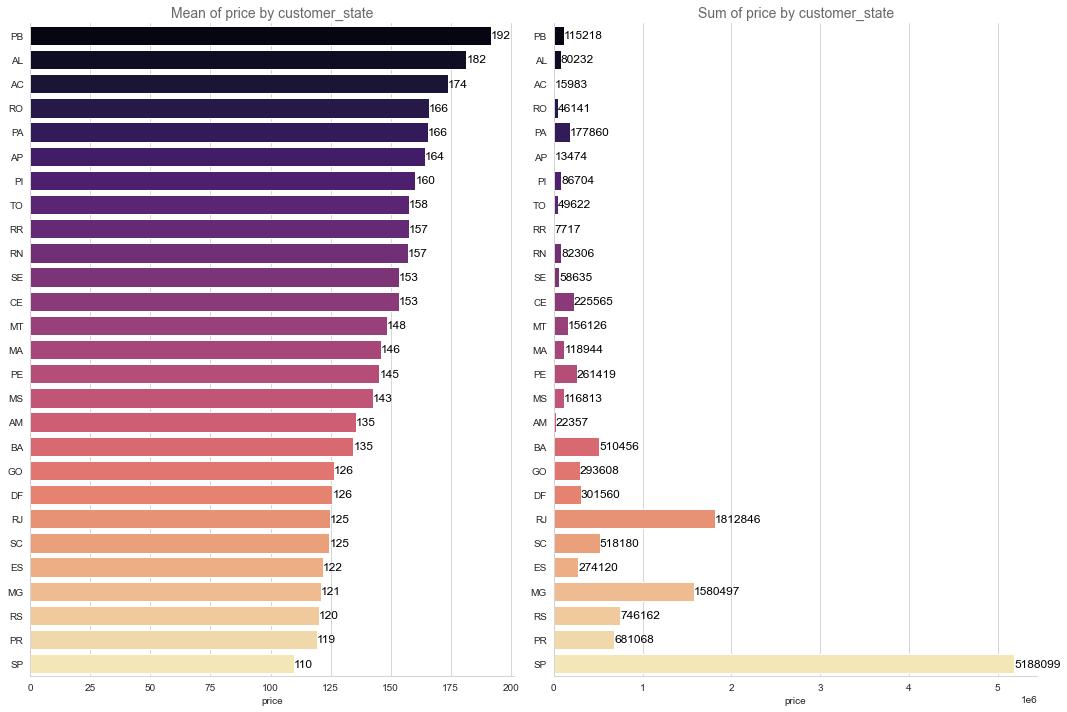

In [107]:
mean_sum_analysis(df_orders_filt, 'customer_state', 'price', palette='magma', figsize=(15, 10))

Remarque :

- Nous pouvons voir comment certains États ont <strong> un montant total vendu élevé et un prix bas par commande.</strong> Si nous regardons SP (São Paulo) par exemple, il est possible de voir que c'est l'état avec <strong>l'état le plus précieux pour le commerce électronique (5 188 099 vendus) mais c'est aussi là où les clients paient le moins par commande (110,00 par commande).</strong>

Qu'en est-il du fret ?

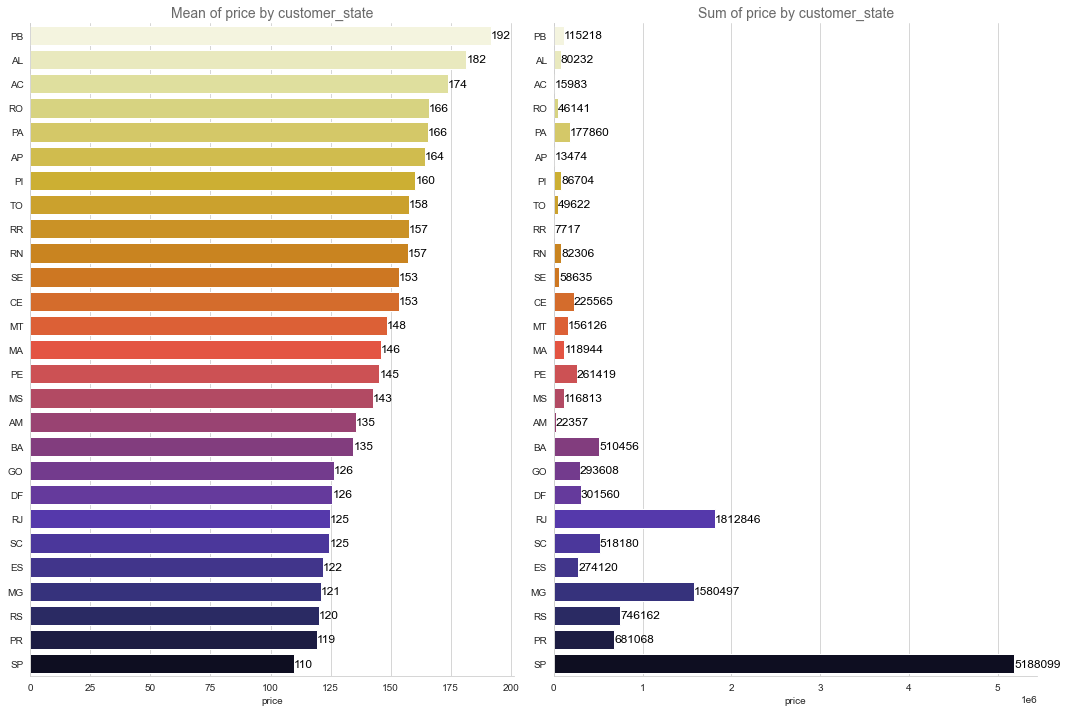

In [108]:
mean_sum_analysis(df_orders_filt, 'customer_state', 'price', palette='CMRmap_r', figsize=(15, 10))

In [109]:
# Calculating working days between purchasing, delivering and estimated delivery
purchasing = df_orders_filt['order_purchase_timestamp']
delivered = df_orders_filt['order_delivered_customer_date']
estimated = df_orders_filt['order_estimated_delivery_date']
df_orders_filt['time_to_delivery'] = calc_working_days(purchasing, delivered, convert=True)
df_orders_filt['diff_estimated_delivery'] = calc_working_days(estimated, delivered, convert=True)

# Grouping data by state
states_avg_grouped = df_orders_filt.groupby(by='customer_state', as_index=False).mean()
states_freight_paid = states_avg_grouped.loc[:, ['customer_state', 'freight_value']]
states_time_to_delivery = states_avg_grouped.loc[:, ['customer_state', 'time_to_delivery']]
states_estimated_delivery = states_avg_grouped.loc[:, ['customer_state', 'diff_estimated_delivery']]

# Sorting data
states_freight_paid = states_freight_paid.sort_values(by='freight_value', ascending=False)
states_time_to_delivery = states_time_to_delivery.sort_values(by='time_to_delivery', ascending=False)
states_estimated_delivery = states_estimated_delivery.sort_values(by='diff_estimated_delivery')


Ici, nous pouvons obtenir des informations sur les États clients avec la valeur de fret moyenne la plus élevée.<strong> Par exemple, les clients de Roraima (RR), Paraíba (PB), Rondônia (RO) et Acre (AC) paient normalement plus que quiconque sur les frets.</strong>

Quels sont les meilleurs états pour acheter au Brésil ? Une analyse des ventes, du fret et des délais de livraison

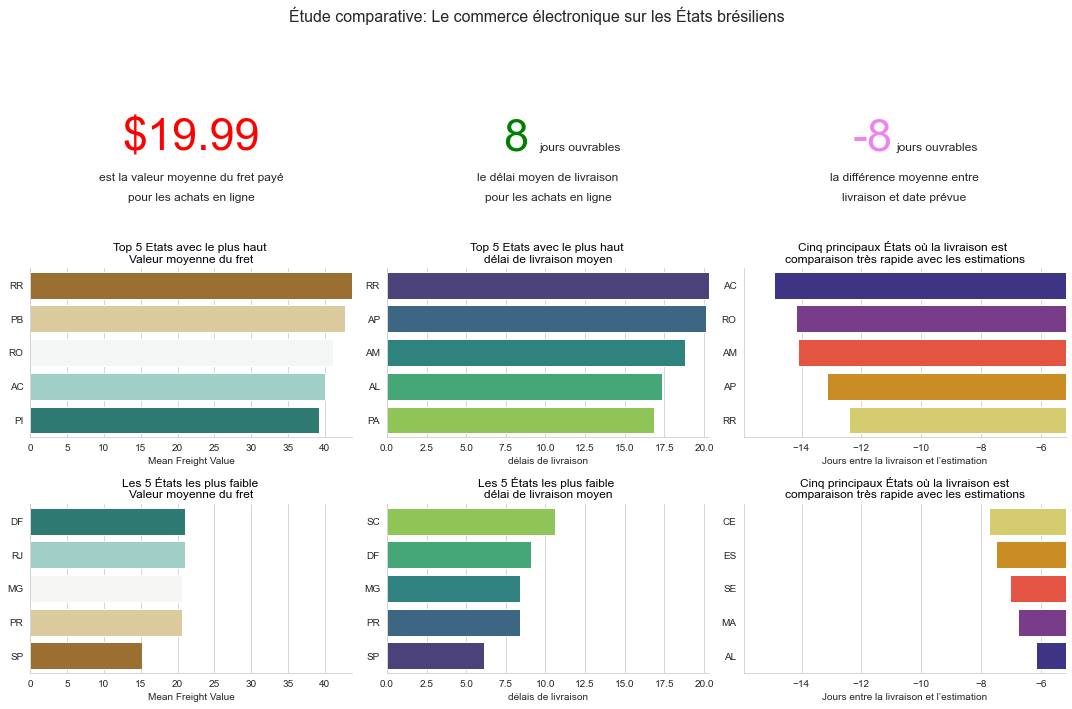

In [110]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Plot Pack 01 - Freight value paid on states
sns.barplot(x='freight_value', y='customer_state', data=states_freight_paid.head(), ax=axs[1, 0], palette='BrBG')
axs[1, 0].set_title('Top 5 Etats avec le plus haut \nValeur moyenne du fret', size=12, color='black')
sns.barplot(x='freight_value', y='customer_state', data=states_freight_paid.tail(), ax=axs[2, 0], palette='BrBG_r')
axs[2, 0].set_title('Les 5 États les plus faible \nValeur moyenne du fret', size=12, color='black')
for ax in axs[1, 0], axs[2, 0]:
    ax.set_xlabel('Mean Freight Value')
    ax.set_xlim(0, states_freight_paid['freight_value'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 0].text(0.50, 0.30, f'${round(df_orders_filt.freight_value.mean(), 2)}', fontsize=45, ha='center',color='red')
axs[0, 0].text(0.50, 0.12, 'est la valeur moyenne du fret payé', fontsize=12, ha='center')
axs[0, 0].text(0.50, 0.00, 'pour les achats en ligne', fontsize=12, ha='center')
axs[0, 0].axis('off')

# Plot Pack 02 - Time to delivery on states
sns.barplot(x='time_to_delivery', y='customer_state', data=states_time_to_delivery.head(), ax=axs[1, 1], palette='viridis')
axs[1, 1].set_title('Top 5 Etats avec le plus haut \ndélai de livraison moyen', size=12, color='black')
sns.barplot(x='time_to_delivery', y='customer_state', data=states_time_to_delivery.tail(), ax=axs[2, 1], palette='viridis_r')
axs[2, 1].set_title('Les 5 États les plus faible \ndélai de livraison moyen', size=12, color='black')
for ax in axs[1, 1], axs[2, 1]:
    ax.set_xlabel('délais de livraison')
    ax.set_xlim(0, states_time_to_delivery['time_to_delivery'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')
    
# Annotations
axs[0, 1].text(0.40, 0.30, f'{int(df_orders_filt.time_to_delivery.mean())}', fontsize=45, ha='center',color='green')
axs[0, 1].text(0.60, 0.30, 'jours ouvrables', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.12, 'le délai moyen de livraison', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.00, 'pour les achats en ligne', fontsize=12, ha='center')
axs[0, 1].axis('off')
    
# Plot Pack 03 - Differnece between delivered and estimated on states
sns.barplot(x='diff_estimated_delivery', y='customer_state', data=states_estimated_delivery.head(), ax=axs[1, 2], palette='CMRmap')
axs[1, 2].set_title('Cinq principaux États où la livraison est \ncomparaison très rapide avec les estimations', size=12, color='black')
sns.barplot(x='diff_estimated_delivery', y='customer_state', data=states_estimated_delivery.tail(), ax=axs[2, 2], palette='CMRmap_r')
axs[2, 2].set_title('Cinq principaux États où la livraison est\ncomparaison très rapide avec les estimations', size=12, color='black')
for ax in axs[1, 2], axs[2, 2]:
    ax.set_xlabel('Jours entre la livraison et l’estimation')
    ax.set_xlim(states_estimated_delivery['diff_estimated_delivery'].min()-1, 
                states_estimated_delivery['diff_estimated_delivery'].max()+1)
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 2].text(0.40, 0.30, f'{int(df_orders_filt.diff_estimated_delivery.mean())}', fontsize=45, ha='center',color='violet')
axs[0, 2].text(0.60, 0.30, 'jours ouvrables', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.12, 'la différence moyenne entre', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.00, 'livraison et date prévue', fontsize=12, ha='center')
axs[0, 2].axis('off') 
    
plt.suptitle('Étude comparative: Le commerce électronique sur les États brésiliens', size=16)
plt.tight_layout()
plt.show()

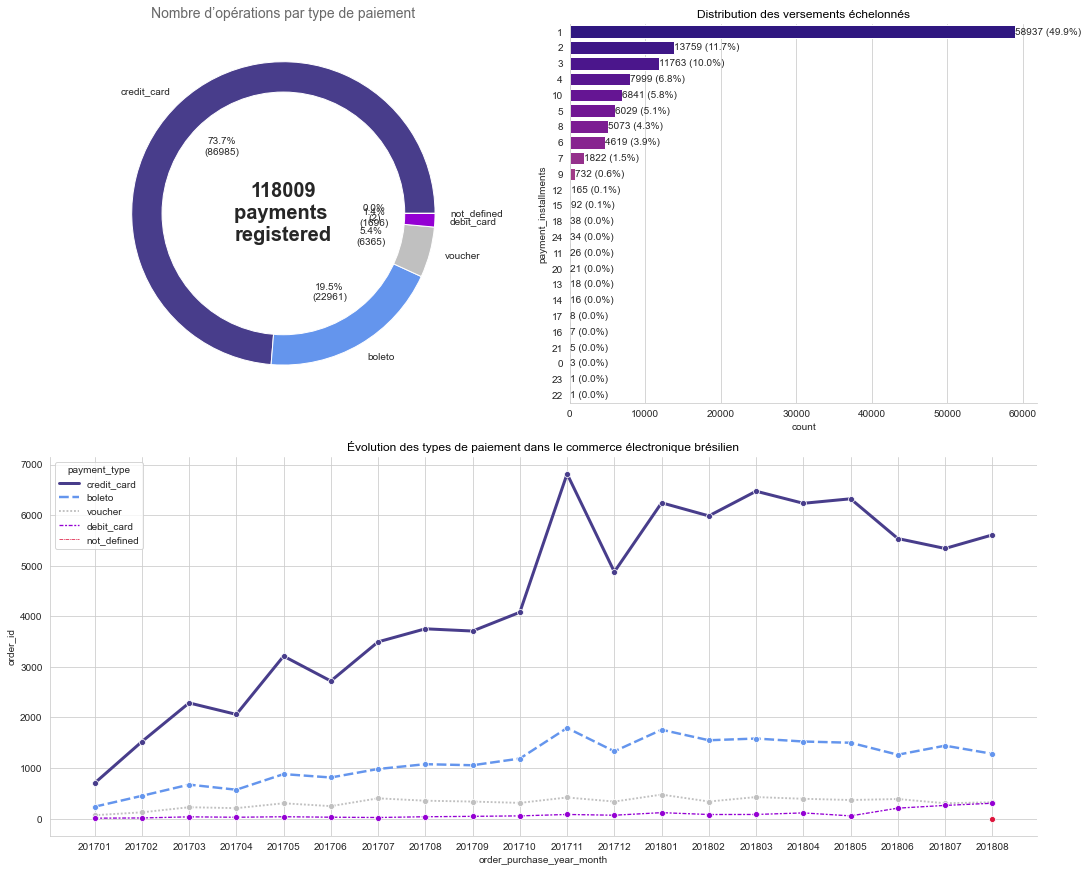

In [111]:
# Grouping data
df_orders_pay = df_orders_filt.merge(olist_order_payments, how='left', on='order_id')

# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Plot 1 - Payment types in a donut chart
colors = ['darkslateblue', 'cornflowerblue', 'silver', 'darkviolet', 'crimson']
label_names = df_orders_pay['payment_type'].value_counts().index
donut_plot(df_orders_pay, col='payment_type', ax=ax1, label_names=label_names, colors=colors,
           title='Nombre d’opérations par type de paiement', text=f'{len(df_orders_pay)}\npayments \nregistered')

# Plot 2 - Payment installments
single_countplot(df_orders_pay, ax=ax2, y='payment_installments')
ax2.set_title('Distribution des versements échelonnés', color='black', size=12)

# Plot 3 - Evolution of payment types
payment_evl = df_orders_pay.groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False).count()
payment_evl = payment_evl.loc[:, ['order_purchase_year_month', 'payment_type', 'order_id']]
payment_evl = payment_evl.sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False])
sns.lineplot(x='order_purchase_year_month', y='order_id', data=payment_evl, ax=ax3, hue='payment_type',
             style='payment_type', size='payment_type', palette=colors, marker='o')
format_spines(ax3, right_border=False)
ax3.set_title('Évolution des types de paiement dans le commerce électronique brésilien', size=12, color='black')
plt.show()

Remarque :

- Nous pouvons voir par le graphique linéaire que les paiements effectués par carte de crédit ont vraiment pris une place prépondérante sur le e-commerce brésilien.

- De plus, depuis 2018-03, il est possible de voir <strong>une petite baisse sur ce type de paiement.</strong> De l'autre côté, les paiements effectués par carte de débit montrent <strong> une tendance à la hausse depuis 2018-05,</strong> ce qui est une bonne opportunité pour les investisseurs d'améliorer les services pour les paiements comme celui-ci.

- Nous pouvons voir comment les clients brésiliens préfèrent payer les commandes : la plupart d'entre eux paient une fois en 1 fois.

------------------

In [112]:
m = folium.Map(location=[-25.43045, -49.29207], 
               tiles = 'Stamen Terrain')

# Add marker for Boulder, CO
folium.Marker(
    location=[-25.43045, -49.29207], # coordinates for the marker (Earth Lab at CU Boulder)
    popup='Siège sociale OList', # pop-up label for the marker
    icon=folium.Icon()
).add_to(m)



X = df3[['geolocation_lat', 'geolocation_lng', 'Flag and name']].copy()
# mark each station as a point
for index, row in X.iterrows():
    folium.CircleMarker([row['geolocation_lat'], row['geolocation_lng']],
                        radius=15,
                        popup=row['Flag and name'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)

# convert to (n, 2) nd-array format for heatmap
stationArr = df3[['geolocation_lat', 'geolocation_lng']].to_numpy()

# plot heatmap
m.add_child(plugins.HeatMap(stationArr, radius=15))
m

------------------

In [113]:
state_location.head()

Flag and name  geolocation_lat  geolocation_lng
0          Acre        -9.702555       -68.451852
1       Alagoas        -9.599729       -36.052017
2         Amapá         0.086025       -51.234304
3      Amazonas        -3.349336       -60.537430
4         Bahia       -13.049361       -39.560649

In [114]:
def haversine_distance(lat1,lng1,lat2,lng2,degrees=True):
    r= 3956 #Rayon de la Terre en miles

    if degrees:
        lat1,lng1,lat2,lng2 = map(radians,[lat1,lng1,lat2,lng2])

    #Formule Haversine
    dlng = lng2 - lng1
    dlat = lat2 - lat1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) *sin(dlng/2)**2
    d = 2*r*asin(sqrt(a))

    return d
     

In [115]:
# Distance Haversine entre le centre des états et le siège social de OList:

state_location['harvesine_distance'] = [haversine_distance(olist_lat,olist_lon,x,y)
                                       for x,y in zip(state_location.geolocation_lat,
                                                      state_location.geolocation_lng)] 

In [116]:
data_final = pd.merge(data_final, state_location[["Flag and name", "harvesine_distance"]],
         how="left",
         left_on="customer_state",
         right_on="Flag and name")
data_final.drop("index", axis=1, inplace=True)
data_final.set_index("customer_unique_id", inplace=True)
data_final.head()

nb_orders  total_spend  \
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2          1       141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f          1        27.19   
0000f46a3911fa3c0805444483337064          1        86.22   
0000f6ccb0745a6a4b88665a16c9f078          1        43.62   
0004aac84e0df4da2b147fca70cf8255          1       196.89   

                                  mean_payment_sequential  \
customer_unique_id                                          
0000366f3b9a7992bf8c76cfdf3221e2                      1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                      1.0   
0000f46a3911fa3c0805444483337064                      1.0   
0000f6ccb0745a6a4b88665a16c9f078                      1.0   
0004aac84e0df4da2b147fca70cf8255                      1.0   

                                  mean_payment_installments  \
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2                        8.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                        1.0   
0000f46a3911fa3c0805444483337064                        8.0   
0000f6ccb0745a6a4b88665a16c9f078                        4.0   
0004aac84e0df4da2b147fca70cf8255                        6.0   

                                  mean_review_score  mean_delivery_days  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2                5.0                 6.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                4.0                 3.0   
0000f46a3911fa3c0805444483337064                3.0                26.0   
0000f6ccb0745a6a4b88665a16c9f078                4.0                20.0   
0004aac84e0df4da2b147fca70cf8255                5.0                13.0   

                                  favorite_sale_month  books_cds_media  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2                    5              0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                    5              0.0   
0000f46a3911fa3c0805444483337064                    3              0.0   
0000f6ccb0745a6a4b88665a16c9f078                   10              0.0   
0004aac84e0df4da2b147fca70cf8255                   11              0.0   

                                  fashion_clothing_accessories  flowers_gifts  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2                           0.0            0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                           0.0            0.0   
0000f46a3911fa3c0805444483337064                           0.0            0.0   
0000f6ccb0745a6a4b88665a16c9f078                           0.0            0.0   
0004aac84e0df4da2b147fca70cf8255                           0.0            0.0   

                                  ...  total_items  mean_nb_items  \
customer_unique_id                ...                               
0000366f3b9a7992bf8c76cfdf3221e2  ...          1.0            1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f  ...          1.0            1.0   
0000f46a3911fa3c0805444483337064  ...          1.0            1.0   
0000f6ccb0745a6a4b88665a16c9f078  ...          1.0            1.0   
0004aac84e0df4da2b147fca70cf8255  ...          1.0            1.0   

                                   order_mean_delay  freight_ratio  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2  111 days 00:00:00           0.08   
0000b849f77a49e4a4ce2b2a4ca5be3f  114 days 00:00:00           0.30   
0000f46a3911fa3c0805444483337064  537 days 00:00:00           0.20   
0000f6ccb0745a6a4b88665a16c9f078  321 days 00:00:00           0.40   
0004aac84e0df4da2b147fca70cf8255  288 days 00:00:00           0.09   

                                  mean_price_order  customer_zip_code_prefix  \
customer_unique_id                                                         

In [117]:
data_final.head()

nb_orders  total_spend  \
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2          1       141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f          1        27.19   
0000f46a3911fa3c0805444483337064          1        86.22   
0000f6ccb0745a6a4b88665a16c9f078          1        43.62   
0004aac84e0df4da2b147fca70cf8255          1       196.89   

                                  mean_payment_sequential  \
customer_unique_id                                          
0000366f3b9a7992bf8c76cfdf3221e2                      1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                      1.0   
0000f46a3911fa3c0805444483337064                      1.0   
0000f6ccb0745a6a4b88665a16c9f078                      1.0   
0004aac84e0df4da2b147fca70cf8255                      1.0   

                                  mean_payment_installments  \
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2                        8.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                        1.0   
0000f46a3911fa3c0805444483337064                        8.0   
0000f6ccb0745a6a4b88665a16c9f078                        4.0   
0004aac84e0df4da2b147fca70cf8255                        6.0   

                                  mean_review_score  mean_delivery_days  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2                5.0                 6.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                4.0                 3.0   
0000f46a3911fa3c0805444483337064                3.0                26.0   
0000f6ccb0745a6a4b88665a16c9f078                4.0                20.0   
0004aac84e0df4da2b147fca70cf8255                5.0                13.0   

                                  favorite_sale_month  books_cds_media  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2                    5              0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                    5              0.0   
0000f46a3911fa3c0805444483337064                    3              0.0   
0000f6ccb0745a6a4b88665a16c9f078                   10              0.0   
0004aac84e0df4da2b147fca70cf8255                   11              0.0   

                                  fashion_clothing_accessories  flowers_gifts  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2                           0.0            0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                           0.0            0.0   
0000f46a3911fa3c0805444483337064                           0.0            0.0   
0000f6ccb0745a6a4b88665a16c9f078                           0.0            0.0   
0004aac84e0df4da2b147fca70cf8255                           0.0            0.0   

                                  ...  total_items  mean_nb_items  \
customer_unique_id                ...                               
0000366f3b9a7992bf8c76cfdf3221e2  ...          1.0            1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f  ...          1.0            1.0   
0000f46a3911fa3c0805444483337064  ...          1.0            1.0   
0000f6ccb0745a6a4b88665a16c9f078  ...          1.0            1.0   
0004aac84e0df4da2b147fca70cf8255  ...          1.0            1.0   

                                   order_mean_delay  freight_ratio  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2  111 days 00:00:00           0.08   
0000b849f77a49e4a4ce2b2a4ca5be3f  114 days 00:00:00           0.30   
0000f46a3911fa3c0805444483337064  537 days 00:00:00           0.20   
0000f6ccb0745a6a4b88665a16c9f078  321 days 00:00:00           0.40   
0004aac84e0df4da2b147fca70cf8255  288 days 00:00:00           0.09   

                                  mean_price_order  customer_zip_code_prefix  \
customer_unique_id                                                         

In [118]:
data_final.columns

Index(['nb_orders', 'total_spend', 'mean_payment_sequential',
       'mean_payment_installments', 'mean_review_score', 'mean_delivery_days',
       'favorite_sale_month', 'books_cds_media',
       'fashion_clothing_accessories', 'flowers_gifts', 'groceries_food_drink',
       'health_beauty', 'home_furniture', 'other', 'sport', 'technology',
       'toys_baby', 'total_items', 'mean_nb_items', 'order_mean_delay',
       'freight_ratio', 'mean_price_order', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'Flag and name',
       'harvesine_distance'],
      dtype='object')

Corrélations :
Nous allons à présent regarder s'il existe des corrélations linéaires fortes dans le jeu de données :

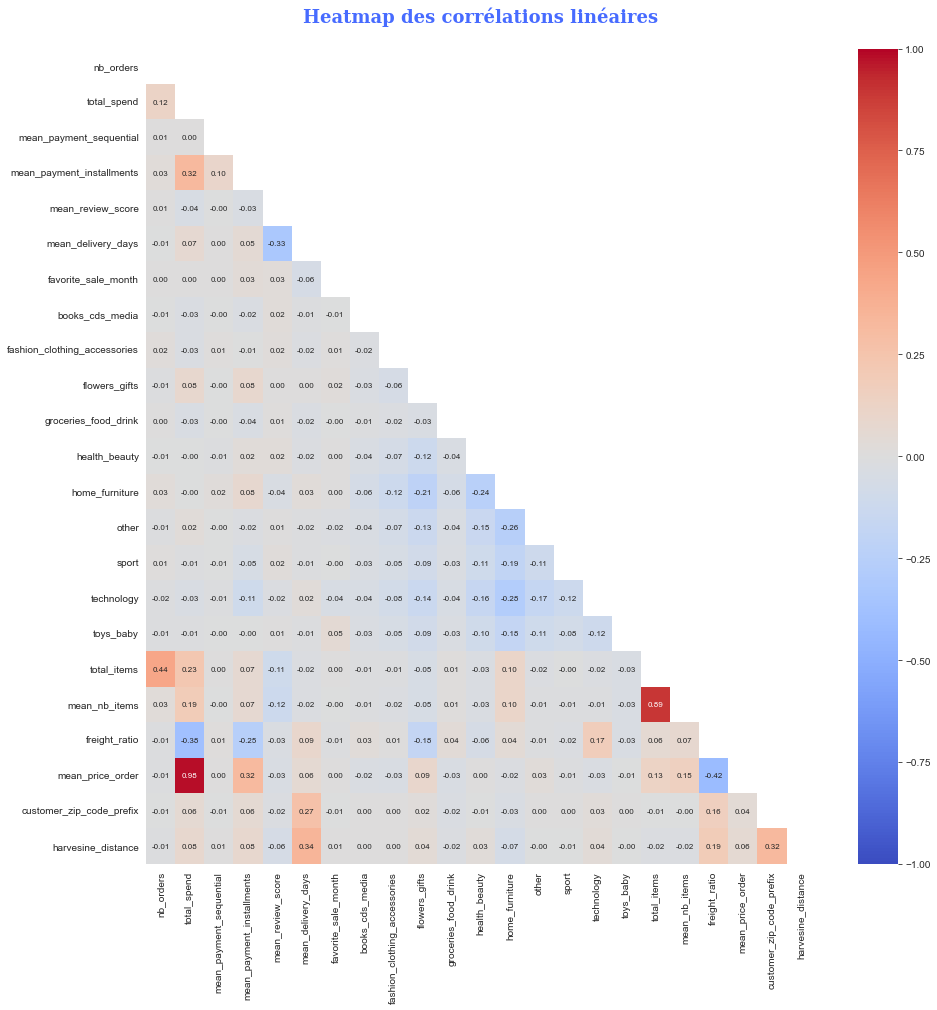

In [119]:
corr = data_final.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, annot=True,
                 vmin=-1, vmax=1,
                 fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, 
                 center=0, 
                 cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", 
          fontdict=font_title)
plt.show()

Remarque : 

- Le prix total est fortement corrélé au prix moyen par commande.
- De même pour le nombre d'articles moyen et Total. => probablement dû au fait que la plupart des clients ne passe qu'une seule commande à la fois.

- L'inverse les autres features sont très peu corrélées 

In [120]:
data_final.head()

nb_orders  total_spend  \
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2          1       141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f          1        27.19   
0000f46a3911fa3c0805444483337064          1        86.22   
0000f6ccb0745a6a4b88665a16c9f078          1        43.62   
0004aac84e0df4da2b147fca70cf8255          1       196.89   

                                  mean_payment_sequential  \
customer_unique_id                                          
0000366f3b9a7992bf8c76cfdf3221e2                      1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                      1.0   
0000f46a3911fa3c0805444483337064                      1.0   
0000f6ccb0745a6a4b88665a16c9f078                      1.0   
0004aac84e0df4da2b147fca70cf8255                      1.0   

                                  mean_payment_installments  \
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2                        8.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                        1.0   
0000f46a3911fa3c0805444483337064                        8.0   
0000f6ccb0745a6a4b88665a16c9f078                        4.0   
0004aac84e0df4da2b147fca70cf8255                        6.0   

                                  mean_review_score  mean_delivery_days  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2                5.0                 6.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                4.0                 3.0   
0000f46a3911fa3c0805444483337064                3.0                26.0   
0000f6ccb0745a6a4b88665a16c9f078                4.0                20.0   
0004aac84e0df4da2b147fca70cf8255                5.0                13.0   

                                  favorite_sale_month  books_cds_media  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2                    5              0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                    5              0.0   
0000f46a3911fa3c0805444483337064                    3              0.0   
0000f6ccb0745a6a4b88665a16c9f078                   10              0.0   
0004aac84e0df4da2b147fca70cf8255                   11              0.0   

                                  fashion_clothing_accessories  flowers_gifts  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2                           0.0            0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                           0.0            0.0   
0000f46a3911fa3c0805444483337064                           0.0            0.0   
0000f6ccb0745a6a4b88665a16c9f078                           0.0            0.0   
0004aac84e0df4da2b147fca70cf8255                           0.0            0.0   

                                  ...  total_items  mean_nb_items  \
customer_unique_id                ...                               
0000366f3b9a7992bf8c76cfdf3221e2  ...          1.0            1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f  ...          1.0            1.0   
0000f46a3911fa3c0805444483337064  ...          1.0            1.0   
0000f6ccb0745a6a4b88665a16c9f078  ...          1.0            1.0   
0004aac84e0df4da2b147fca70cf8255  ...          1.0            1.0   

                                   order_mean_delay  freight_ratio  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2  111 days 00:00:00           0.08   
0000b849f77a49e4a4ce2b2a4ca5be3f  114 days 00:00:00           0.30   
0000f46a3911fa3c0805444483337064  537 days 00:00:00           0.20   
0000f6ccb0745a6a4b88665a16c9f078  321 days 00:00:00           0.40   
0004aac84e0df4da2b147fca70cf8255  288 days 00:00:00           0.09   

                                  mean_price_order  customer_zip_code_prefix  \
customer_unique_id                                                         

In [121]:
#Export du dataset final pour classification non-supervisée ( A garder)

data_final.to_csv("olist-customers-segmentation.csv")

In [122]:
#Export du dataset final pour classification non-supervisée (A garder )

#data_final.to_csv(r"C:\Users\mehme\Desktop\GITHUB 00\Projet-5--DS-\olist-customers-segmentation3.csv")

Remarqe : 

 - Nous avons un dataframe final de taille : (93358, 28) 

NOTEBOOK SUIVANT : 

 - À partir du dataset final, nous allons modélise les données pour une classification non-supervisée avec plusieurs modèles : NoteBook 2.

- Enfin établir un contrat de maintenance sur le modèle choisi : NoteBook 3 . 